# Общие сведения

## Краткое описание проекта

В рамках проекта планируется разработать модель машинного обучения предсказывающую риск сердечного приступа, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке.

## План работ

- Провести загрузку и предобработку данных (анализ пропусков, приведение типов и т.п.);
- Провести исследовательский анализ данных, построить графики;
- Провести корреляционный анализ данных;
- Обучить модель;
- Получить предсказание на тестовой выборке;
- Обобщить результаты исследования.

## Описание данных

Датасеты содержат следующие данные:

- `Age` - Возраст пациента
- `Cholesterol` - Уровень холестерина
- `Heart rate` - Частота сердечных сокрашений
- `Diabetes` - Наличие диабета
- `Family History` - Наличие семейной истории болезней
- `Smoking` - Наличие никотиновой зависимости
- `Obesity` - Наличие ожирения
- `Alcohol Consumption` - Употребление алкоголя
- `Exercise Hours Per Week` - Количество часов физических упражнений в неделю
- `Diet` - Номер диеты
- `Previous Heart Problems` - Предыдущие проблемы с сердцем (двоичный)
- `Medication Use` - Прием лекарственных аппаратов
- `Stress Level` - Уровень стресса
- `Sedentary Hours Per Day` - Количество часов сидячего образа жизни в день
- `Income` - Доход
- `BMI` - Индекс массы тела
- `Triglycerides` - Уровень триглицеридов
- `Physical Activity Days Per Week` - Дней физической активности в неделю
- `Sleep Hours Per Day` - Количество часов сна в день
- `Heart Attack Risk (Binary)` - Риск сердечного приступа (целевой признак)
- `Blood sugar` - Уровень сахара в крови
- `CK-MB` - Уровень креатинкиназы МБ
- `Troponin` - Уровень тропонина
- `Gender` - Пол
- `Systolic blood pressure` - Систолическое артериальное давление
- `Diastolic blood pressure` - Диастолическое артериальное давление
- `id` - идентификатор пациентаd - идентификатор пациента

## Загрузка данных

In [1]:
# Загрузим необходимые библиотеки
!pip install -U scikit-learn -q
!pip install xgboost -q

In [2]:
# Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import phik
import pickle
import logging

from pathlib import Path

# Для визуализации данных
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# Для Машинного обучения
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# загружаем классы для преобразования данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler, 
    MaxAbsScaler
)

#Метрики
from sklearn.metrics import roc_auc_score, recall_score, f1_score

# Функция для расчёта матрицы ошибок
from sklearn.metrics import confusion_matrix, log_loss

# Для пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Класс для работы с пропусками
from sklearn.impute import SimpleImputer

# Отображение всех столбцов
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Отключение предупреждений
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Загрузим необходимый датафрейм
df = pd.read_csv('heart_train.csv')

In [4]:
#Выведем первые строки датафрейма df
df.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [5]:
#Изучим общую информацию об датафрейме df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

In [6]:
#сохраняем количество строк
old_df_shape = df.shape[0]
old_df_shape

8685

**Вывод**

В датафрейме 8685 строк. Необходимо откорректировать содержание столбцов к единому стилю. В некоторых столбцах необходимо поменять тип данных. В некоторых столбцах встречаются пропуски данных.

## Предобработка данных

In [7]:
# Приводим название столбцов к единому стилю 
df.columns = df.columns.str.lower().str.replace(': 0','').str.replace('(','').str.replace(')','').str.replace(' ', '_').str.replace('-', '_')

In [8]:
df.columns

Index(['unnamed', 'age', 'cholesterol', 'heart_rate', 'diabetes',
       'family_history', 'smoking', 'obesity', 'alcohol_consumption',
       'exercise_hours_per_week', 'diet', 'previous_heart_problems',
       'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income',
       'bmi', 'triglycerides', 'physical_activity_days_per_week',
       'sleep_hours_per_day', 'heart_attack_risk_binary', 'blood_sugar',
       'ck_mb', 'troponin', 'gender', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'id'],
      dtype='object')

In [9]:
#Выведем информацию о наличии пропусков
df.isna().sum()

unnamed                              0
age                                  0
cholesterol                          0
heart_rate                           0
diabetes                           243
family_history                     243
smoking                            243
obesity                            243
alcohol_consumption                243
exercise_hours_per_week              0
diet                                 0
previous_heart_problems            243
medication_use                     243
stress_level                       243
sedentary_hours_per_day              0
income                               0
bmi                                  0
triglycerides                        0
physical_activity_days_per_week    243
sleep_hours_per_day                  0
heart_attack_risk_binary             0
blood_sugar                          0
ck_mb                                0
troponin                             0
gender                               0
systolic_blood_pressure  

In [10]:
df[df.isna().any(axis=1)]

,unnamed,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
16,16,0.449438,0.49978,0.063245,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.233202,0.026692,0.000777,1.0,0.393548,0.255814,9528
90,90,0.370787,0.49978,0.066911,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.154150,0.004702,0.042043,1.0,0.258065,0.337209,9640
92,92,0.629213,0.49978,0.073327,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.256917,0.012310,0.000777,0.0,0.258065,0.232558,9515
185,185,0.516854,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.559289,0.006704,0.000291,0.0,0.174194,0.151163,9491
188,188,0.269663,0.49978,0.035747,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.112648,0.051218,0.000485,0.0,0.225806,0.162791,9448
204,204,0.674157,0.49978,0.065078,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.120553,0.002299,0.003010,1.0,0.167742,0.162791,9594
247,247,0.629213,0.49978,0.084326,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.150198,0.002933,0.133896,1.0,0.677419,0.720930,9570
392,392,0.370787,0.49978,0.067828,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.197628,0.119858,0.025439,1.0,0.258065,0.453488,9649
415,415,0.415730,0.49978,0.056829,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.140316,0.004435,0.001748,1.0,0.470968,0.593023,9625
416,416,0.404494,0.49978,0.102658,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.193676,0.009540,0.034275,1.0,0.387097,0.372093,9574


У 243 пациентов есть все пропущенные значения. Часть столбцов полностью идентичны. Удалим этих пациентов

In [11]:
df = df.dropna()

In [12]:
#Выведем информацию о наличии пропусков
df.isna().sum()

unnamed                            0
age                                0
cholesterol                        0
heart_rate                         0
diabetes                           0
family_history                     0
smoking                            0
obesity                            0
alcohol_consumption                0
exercise_hours_per_week            0
diet                               0
previous_heart_problems            0
medication_use                     0
stress_level                       0
sedentary_hours_per_day            0
income                             0
bmi                                0
triglycerides                      0
physical_activity_days_per_week    0
sleep_hours_per_day                0
heart_attack_risk_binary           0
blood_sugar                        0
ck_mb                              0
troponin                           0
gender                             0
systolic_blood_pressure            0
diastolic_blood_pressure           0
i

In [13]:
# Изучим столбец 'unnamed'
df['unnamed'].unique()

array([   0,    1,    2, ..., 8682, 8683, 8684], dtype=int64)

Столбец 'unnamed' содержит порядок записей. Для модели он не нужен. Удалим его

In [14]:
df = df.drop('unnamed', axis=1)

In [15]:
# Заменим индексы на id пациентов
df = df.set_index('id')

In [16]:
#Проверим наличие явных дубликатов
df.duplicated().sum()

0

**Вывод**
Привели название столбцов к единому стилю.

У 243 пациентов есть все пропущенные значения. Часть столбцов у них полностью идентичны. Удалили этих пациентов.

Удалили столбец unnamed, заменили индексы на id пациентов.

Явные дубликаты отсутствуют.

## Исследовательский анализ данных

In [17]:
# Функция для построения графиков для качественных данных
def print_barh (df_column):
# Построение горизонтальной диаграммы
    ax = df_column.value_counts(ascending=True).plot(
    kind='barh',
    figsize=(15, 5)
)

# Добавление значений рядом со столбцами
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{width}',
                    (width, p.get_y() + p.get_height() / 2.),
                    ha='left', va='center',
                    xytext=(5, 0),
                    textcoords='offset points')

In [18]:
# Функция для построения графиков для количественных данных
def print_hist (df, col, target, name):
    sns.set()
    f, axes = plt.subplots(1, 1, figsize=(17, 5))
    axes.set_title(name, fontsize=12)
    axes.set_ylabel('Количество пациентов', fontsize=12)
    if target != None:
        sns.histplot(df, bins=25, kde=True, ax=axes, hue=target, x=col)
    else:
        sns.histplot(df, bins=25, kde=True, ax=axes, x=col)
    plt.show();

In [19]:
# Пребразуем столбцы с вещественными числами в целые
columns_int = ['diabetes', 'family_history', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 
               'previous_heart_problems', 'medication_use', 'stress_level', 'physical_activity_days_per_week', 'heart_attack_risk_binary']
df[columns_int] = df[columns_int].astype(int)

In [20]:
# Изучим столбец 'age'
df['age'].describe()

count    8442.000000
mean        0.449008
std         0.232809
min         0.044944
25%         0.247191
50%         0.460674
75%         0.640449
max         0.853933
Name: age, dtype: float64

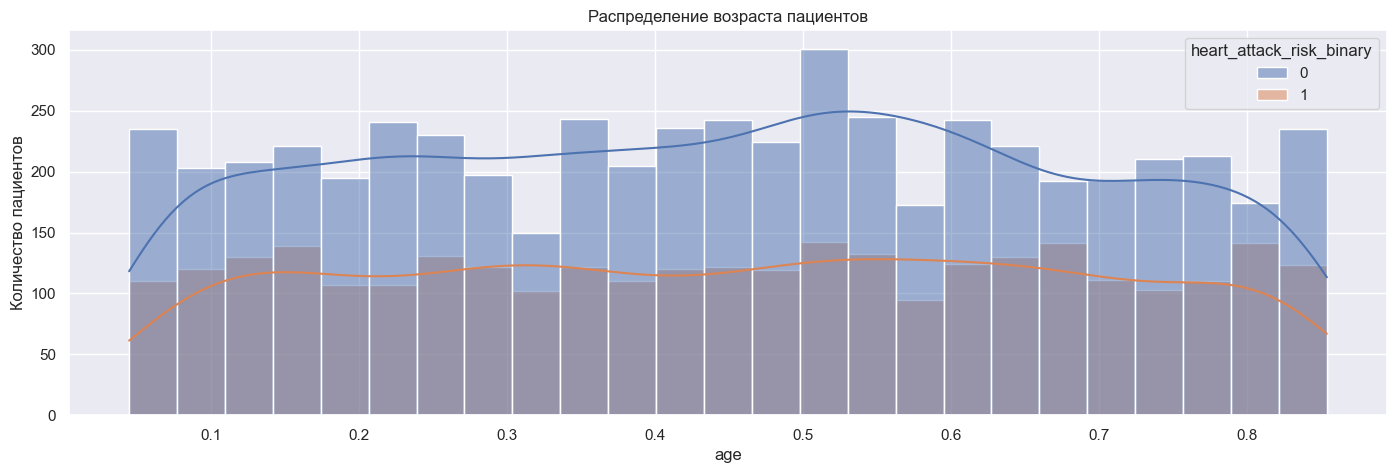

In [21]:
print_hist(df, 
           'age', 
           'heart_attack_risk_binary',
           'Распределение возраста пациентов'
          )

Данные находятся в диапазоне от 0 до 1. Скорее всего данные были заранее нормализованы, что бы не разглашать данные реальных пациентов

In [22]:
# Изучим столбец 'cholesterol'
df['cholesterol'].describe()

count    8442.000000
mean        0.501108
std         0.288785
min         0.000000
25%         0.260714
50%         0.496429
75%         0.750000
max         1.000000
Name: cholesterol, dtype: float64

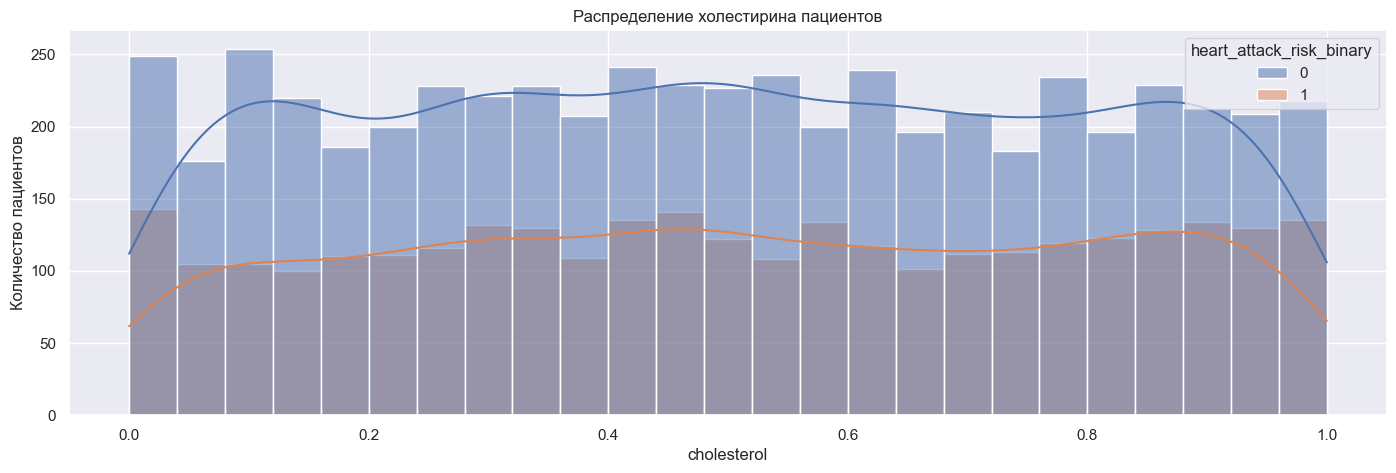

In [23]:
print_hist(df, 
           'cholesterol', 
           'heart_attack_risk_binary',
           'Распределение холестирина пациентов'
          )

Данные находятся в диапазоне от 0 до 1. Значения холестирина измеряется в  ммоль/л и имеют диапазон от 1 до 10. Скорее всего данные были заранее нормализованы, что бы не разглашать данные реальных пациентов

In [24]:
# Изучим столбец 'heart_rate'
df['heart_rate'].describe()

count    8442.000000
mean        0.050194
std         0.018442
min         0.018332
25%         0.034830
50%         0.050412
75%         0.065995
max         0.082493
Name: heart_rate, dtype: float64

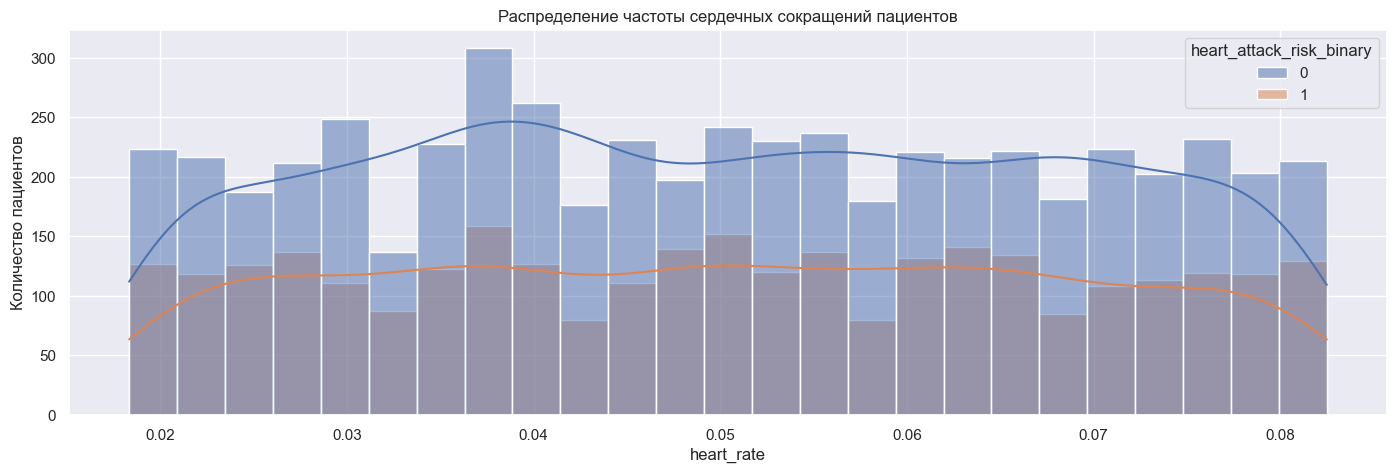

In [25]:
print_hist(df, 
           'heart_rate', 
           'heart_attack_risk_binary',
           'Распределение частоты сердечных сокращений пациентов'
          )

Данные находятся в диапазоне от 0 до 1. Значения частоты сердечных сокращений больше значений из датафрейма. Скорее всего данные были заранее нормализованы, что бы не разглашать данные реальных пациентов

In [26]:
# Изучим столбец 'exercise_hours_per_week'
df['exercise_hours_per_week'].describe()

count    8442.000000
mean        0.503415
std         0.288881
min         0.000000
25%         0.253359
50%         0.508244
75%         0.754901
max         1.000000
Name: exercise_hours_per_week, dtype: float64

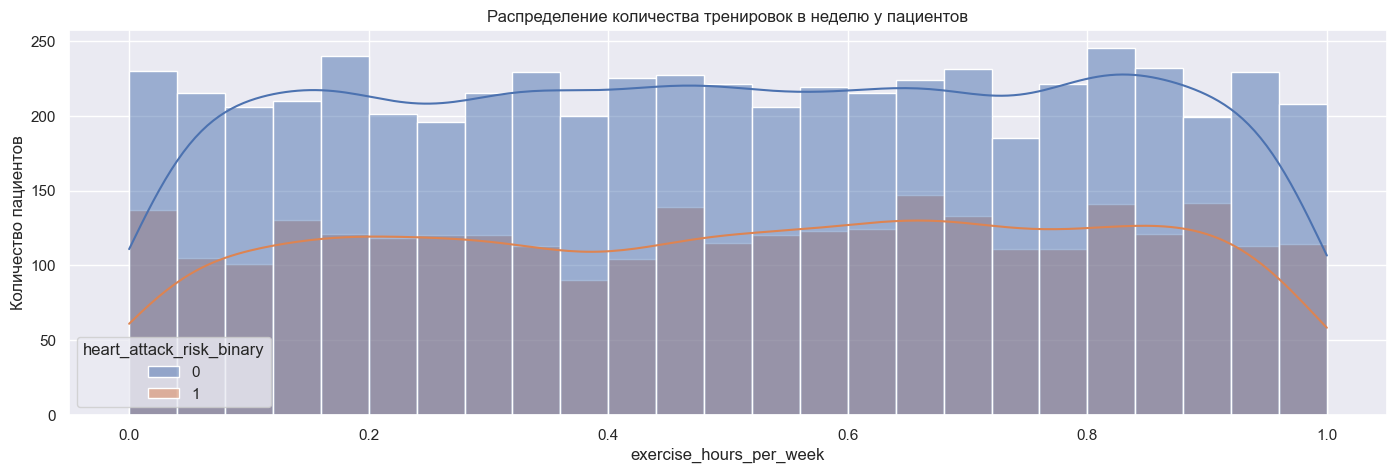

In [27]:
print_hist(df, 
           'exercise_hours_per_week', 
           'heart_attack_risk_binary',
           'Распределение количества тренировок в неделю у пациентов'
          )

Данные находятся в диапазоне от 0 до 1. Значения количества тренировок в неделю больше значений из датафрейма. Скорее всего данные были заранее нормализованы, что бы не разглашать данные реальных пациентов

In [28]:
# Изучим столбец 'sedentary_hours_per_day'
df['sedentary_hours_per_day'].describe()

count    8442.000000
mean        0.499142
std         0.289418
min         0.000000
25%         0.247650
50%         0.492734
75%         0.751047
max         1.000000
Name: sedentary_hours_per_day, dtype: float64

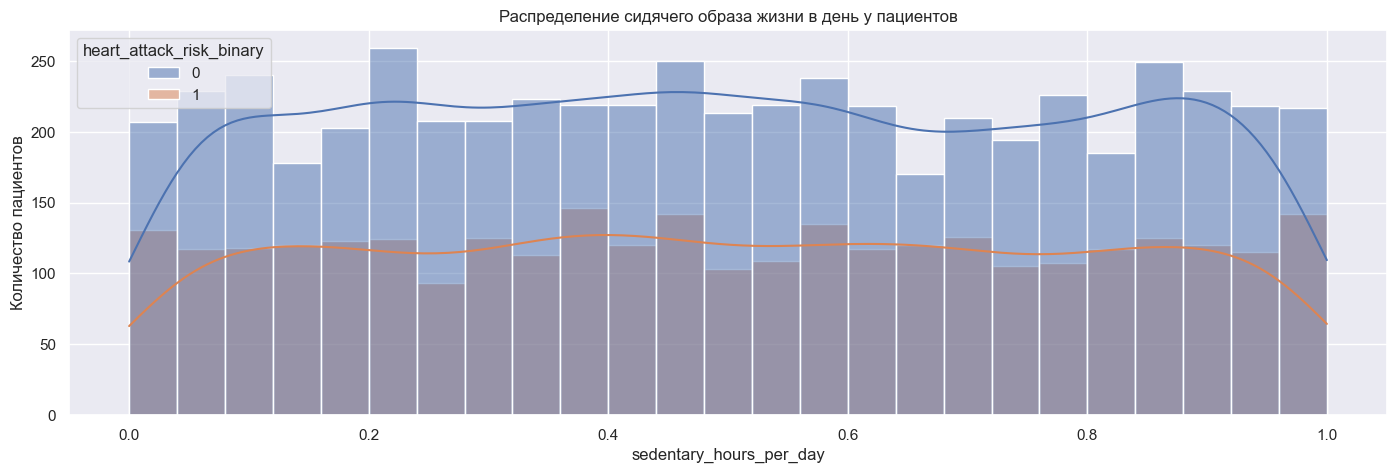

In [29]:
print_hist(df, 
           'sedentary_hours_per_day', 
           'heart_attack_risk_binary',
           'Распределение сидячего образа жизни в день у пациентов'
          )

Данные находятся в диапазоне от 0 до 1. Значения сидячего образа жизни в день больше значений из датафрейма. Скорее всего данные были заранее нормализованы, что бы не разглашать данные реальных пациентов

In [30]:
# Изучим столбец 'income'
df['income'].describe()

count    8442.000000
mean        0.496089
std         0.288767
min         0.000000
25%         0.244591
50%         0.496052
75%         0.747603
max         1.000000
Name: income, dtype: float64

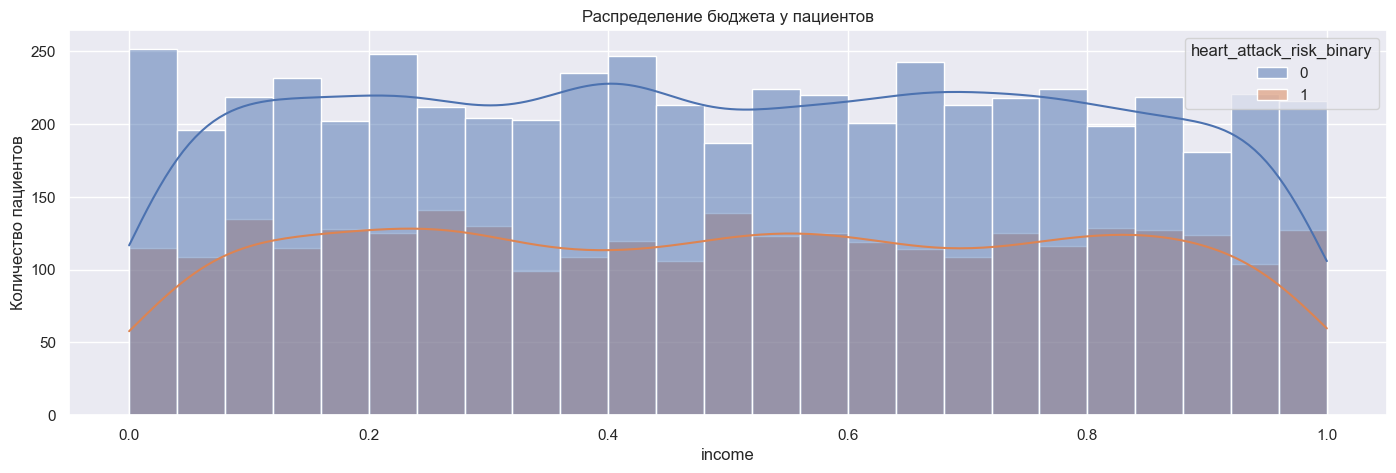

In [31]:
print_hist(df, 
           'income', 
           'heart_attack_risk_binary',
           'Распределение бюджета у пациентов'
          )

Данные находятся в диапазоне от 0 до 1. Значения бюджета пациентов больше значений из датафрейма. Скорее всего данные были заранее нормализованы, что бы не разглашать данные реальных пациентов

In [32]:
# Изучим столбец 'bmi'
df['bmi'].describe()

count    8442.000000
mean        0.496831
std         0.286599
min         0.000000
25%         0.247935
50%         0.490801
75%         0.744399
max         1.000000
Name: bmi, dtype: float64

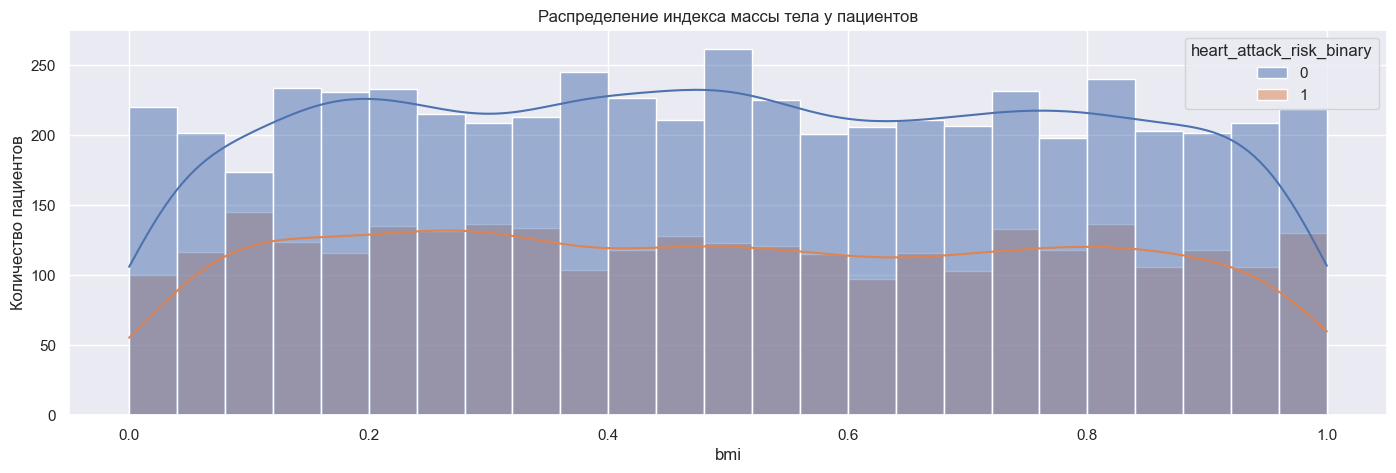

In [33]:
print_hist(df, 
           'bmi', 
           'heart_attack_risk_binary',
           'Распределение индекса массы тела у пациентов'
          )

Данные находятся в диапазоне от 0 до 1. Значения индекса массы тела больше значений из датафрейм. Скорее всего данные были заранее нормализованы, что бы не разглашать данные реальных пациентов

In [34]:
# Изучим столбец 'triglycerides'
df['triglycerides'].describe()

count    8442.000000
mean        0.505539
std         0.290412
min         0.000000
25%         0.257143
50%         0.507792
75%         0.758442
max         1.000000
Name: triglycerides, dtype: float64

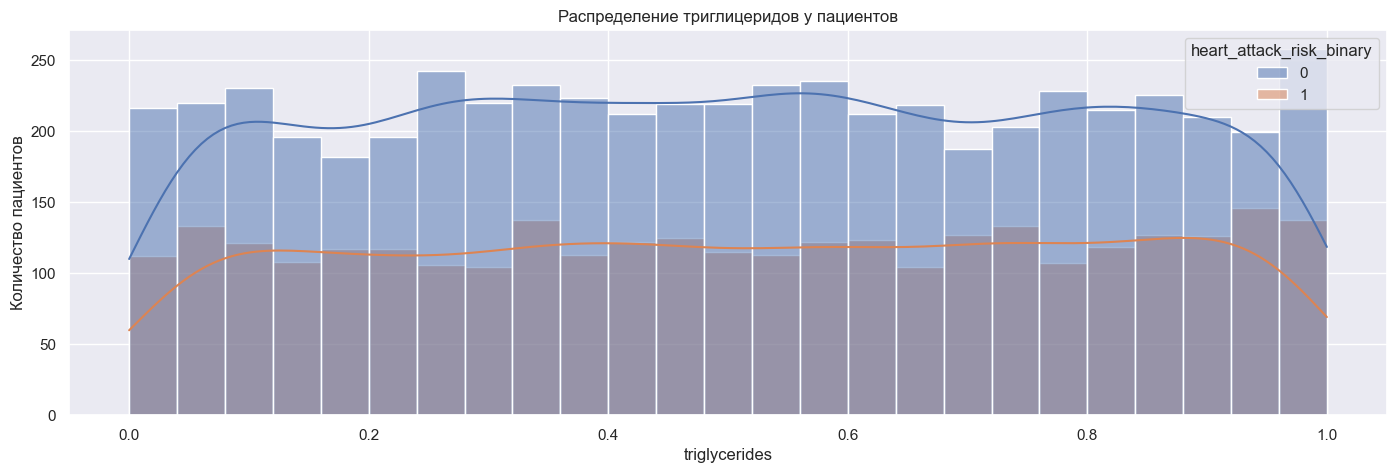

In [35]:
print_hist(df, 
           'triglycerides', 
           'heart_attack_risk_binary',
           'Распределение триглицеридов у пациентов'
          )

Данные находятся в диапазоне от 0 до 1. Значения триглицеридов больше значений из датафрейма. Скорее всего данные были заранее нормализованы, что бы не разглашать данные реальных пациентов

In [36]:
# Изучим столбец 'sleep_hours_per_day'
df['sleep_hours_per_day'].describe()

count    8442.000000
mean        0.503712
std         0.332749
min         0.000000
25%         0.166667
50%         0.500000
75%         0.833333
max         1.000000
Name: sleep_hours_per_day, dtype: float64

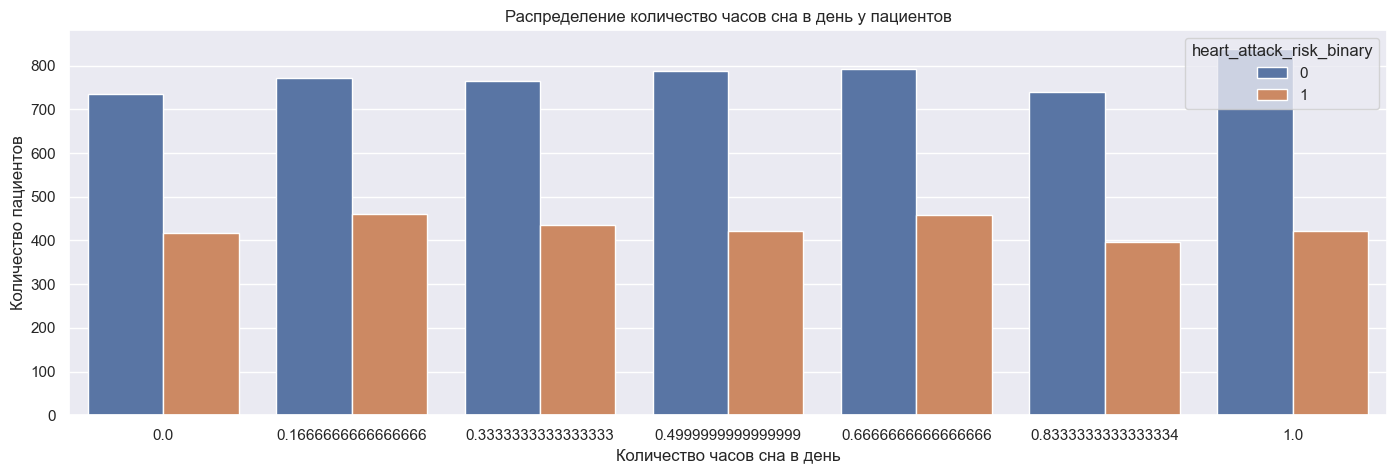

In [37]:
plt.figure(figsize=(17, 5))
sns.countplot(data = df,
              x = 'sleep_hours_per_day', 
              hue = 'heart_attack_risk_binary')
plt.title('Распределение количество часов сна в день у пациентов')
plt.xlabel('Количество часов сна в день')
plt.ylabel('Количество пациентов')
plt.show;

Данные находятся в диапазоне от 0 до 1. Значения количество часов сна в день больше значений из датафрейма. Скорее всего данные были заранее нормализованы, что бы не разглашать данные реальных пациентов

In [38]:
# Изучим столбец 'blood_sugar'
df['blood_sugar'].describe()

count    8442.000000
mean        0.227998
std         0.074623
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: blood_sugar, dtype: float64

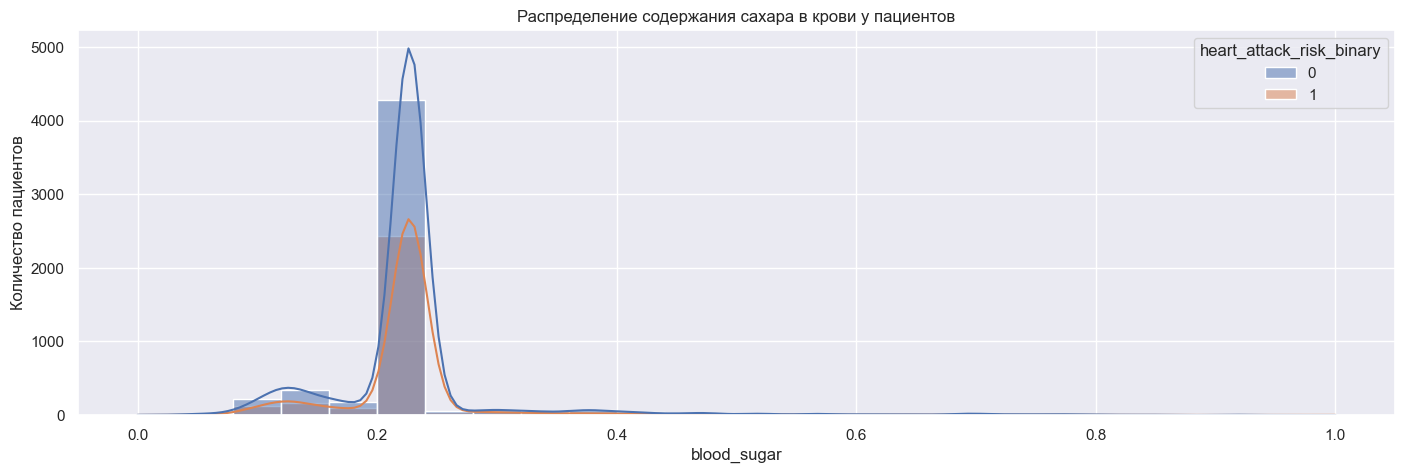

In [39]:
print_hist(df, 
           'blood_sugar', 
           'heart_attack_risk_binary',
           'Распределение содержания сахара в крови у пациентов'
          )

In [40]:
# Изучим столбец 'ck_mb'
df['ck_mb'].describe()

count    8442.000000
mean        0.047745
std         0.070399
min         0.000000
25%         0.048229
50%         0.048229
75%         0.048229
max         1.000000
Name: ck_mb, dtype: float64

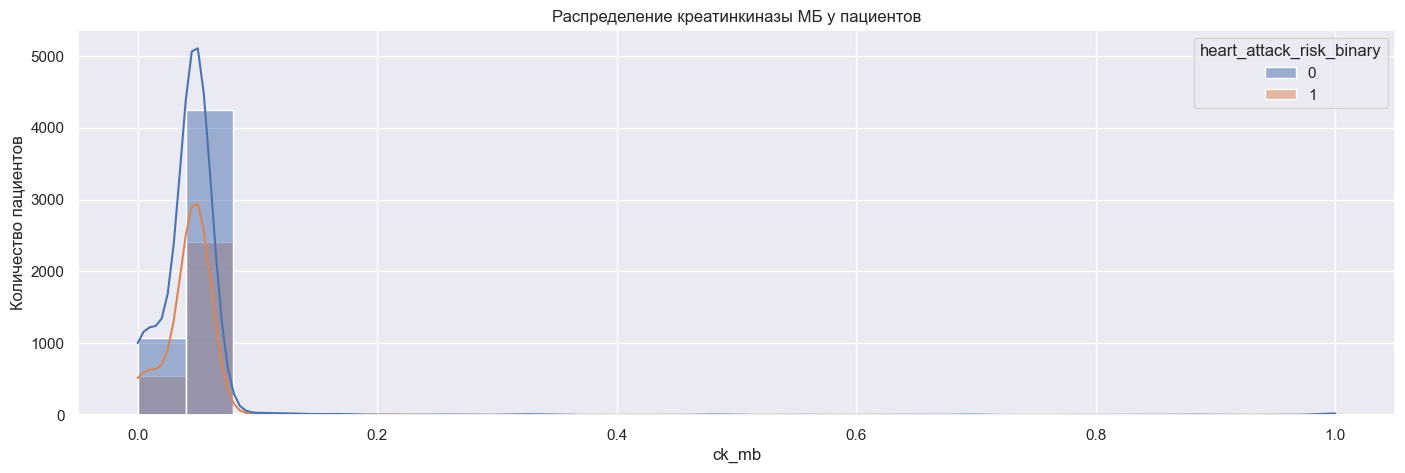

In [41]:
print_hist(df, 
           'ck_mb', 
           'heart_attack_risk_binary',
           'Распределение креатинкиназы МБ у пациентов'
          )

В норме содержание креатинкиназы МБ в крови не превышает 5 нг/мл. Значения выше указывают на инфаркта миокарда.

Добавим новый столбец в котором будут две категории с границей 0,05

In [42]:
df['risk_ck_mb'] = df['ck_mb'].map(lambda x: 1 if x>=0.05 else 0)

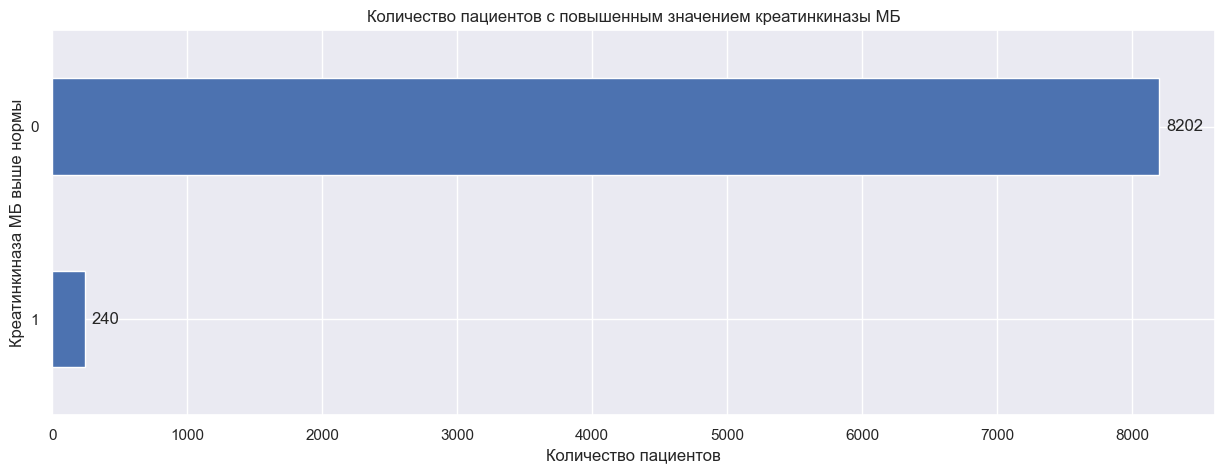

In [43]:
print_barh(df['risk_ck_mb'])
plt.title('Количество пациентов с повышенным значением креатинкиназы МБ')
plt.xlabel('Количество пациентов')
plt.ylabel('Креатинкиназа МБ выше нормы')
plt.show()

In [44]:
# удалим столбец ck_mb
df = df.drop('ck_mb', axis=1)

In [45]:
# Изучим столбец 'troponin'
df['troponin'].describe()

count    8442.000000
mean        0.036867
std         0.059284
min         0.000000
25%         0.036512
50%         0.036512
75%         0.036512
max         1.000000
Name: troponin, dtype: float64

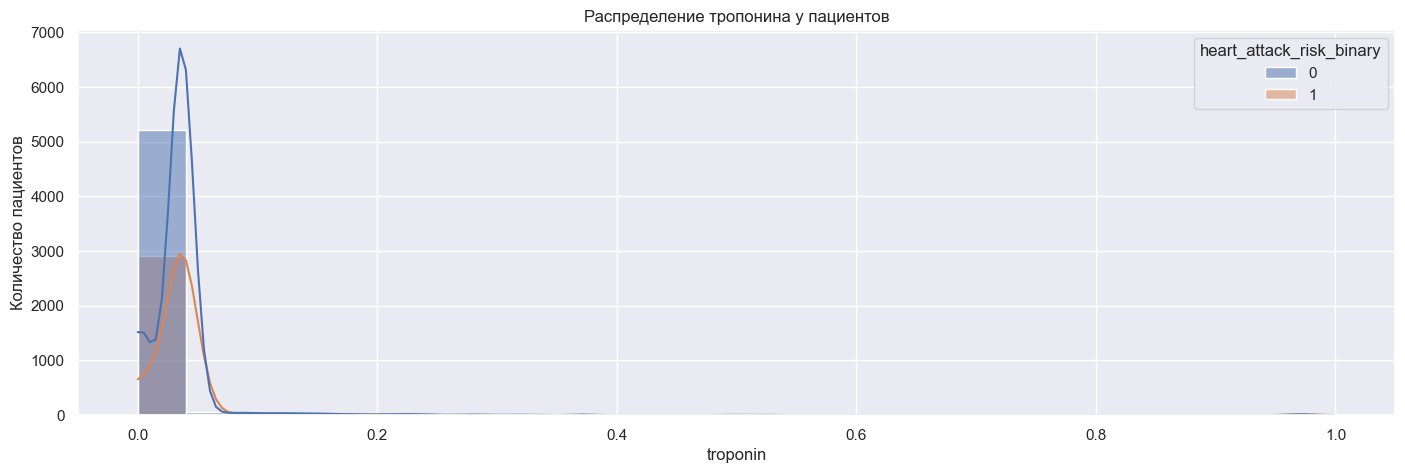

In [46]:
print_hist(df, 
           'troponin', 
           'heart_attack_risk_binary',
           'Распределение тропонина у пациентов'
          )

Значения тропонина менее 0,04 это норма для здорового человека. Значения выше указывают на инфаркта миокарда.

Добавим новый столбец в котором будут две категории с границей 0,04

In [47]:
df['risk_troponin'] = df['troponin'].map(lambda x: 1 if x>=0.04 else 0)

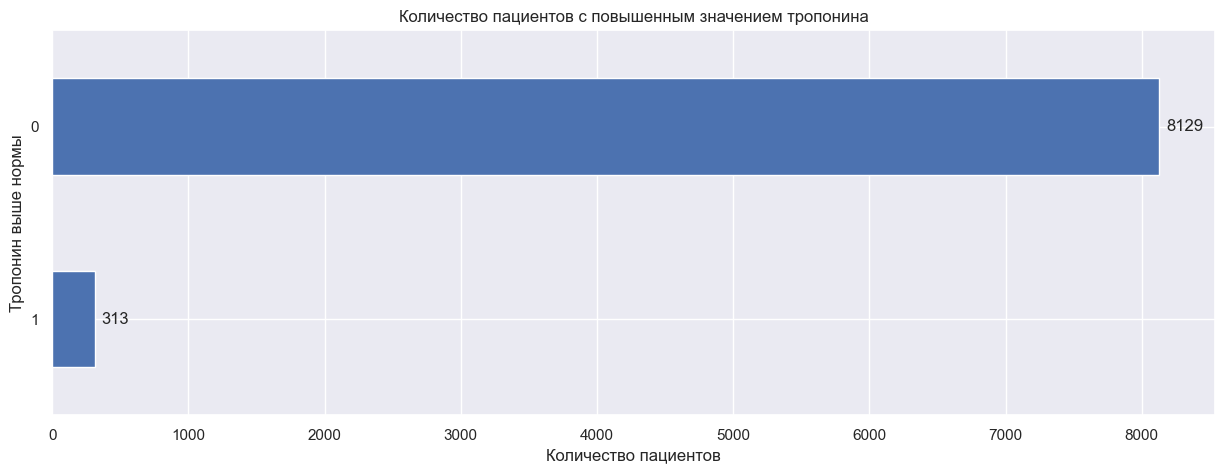

In [48]:
print_barh(df['risk_troponin'])
plt.title('Количество пациентов с повышенным значением тропонина')
plt.xlabel('Количество пациентов')
plt.ylabel('Тропонин выше нормы')
plt.show()

In [49]:
# удалим столбец troponin
df = df.drop('troponin', axis=1)

In [50]:
# Изучим столбец 'systolic_blood_pressure'
df['systolic_blood_pressure'].describe()

count    8442.000000
mean        0.451955
std         0.170187
min         0.161290
25%         0.303226
50%         0.451613
75%         0.600000
max         0.741935
Name: systolic_blood_pressure, dtype: float64

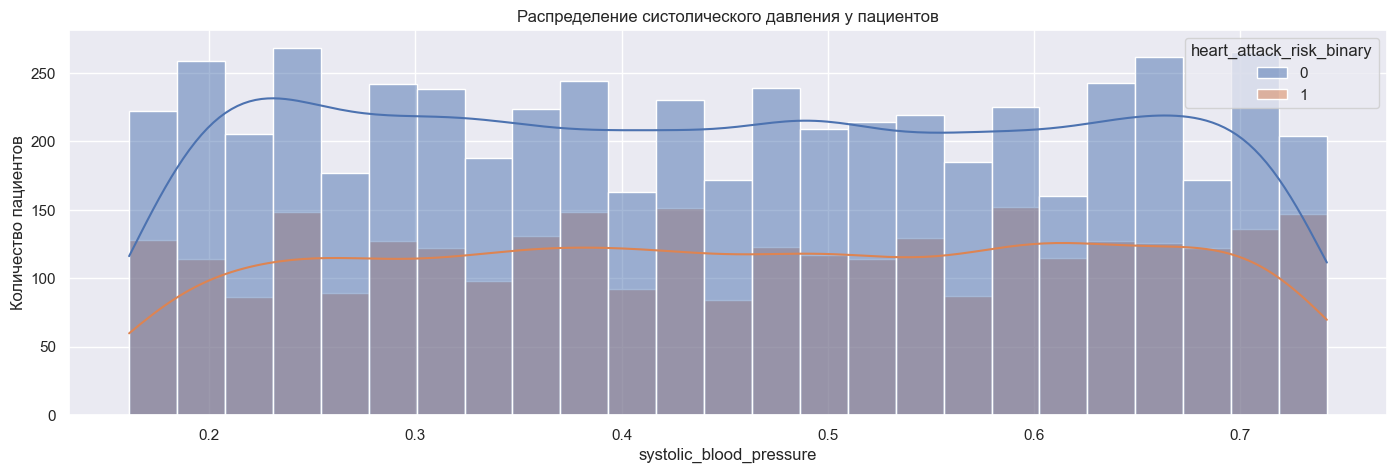

In [51]:
print_hist(df, 
           'systolic_blood_pressure', 
           'heart_attack_risk_binary',
           'Распределение систолического давления у пациентов'
          )

Данные находятся в диапазоне от 0 до 1. Значения систолического давления больше значений из датафрейма. Скорее всего данные были заранее нормализованы, что бы не разглашать данные реальных пациентов

In [52]:
# Изучим столбец 'diastolic_blood_pressure'
df['diastolic_blood_pressure'].describe()

count    8442.000000
mean        0.501672
std         0.170302
min         0.209302
25%         0.348837
50%         0.500000
75%         0.651163
max         0.790698
Name: diastolic_blood_pressure, dtype: float64

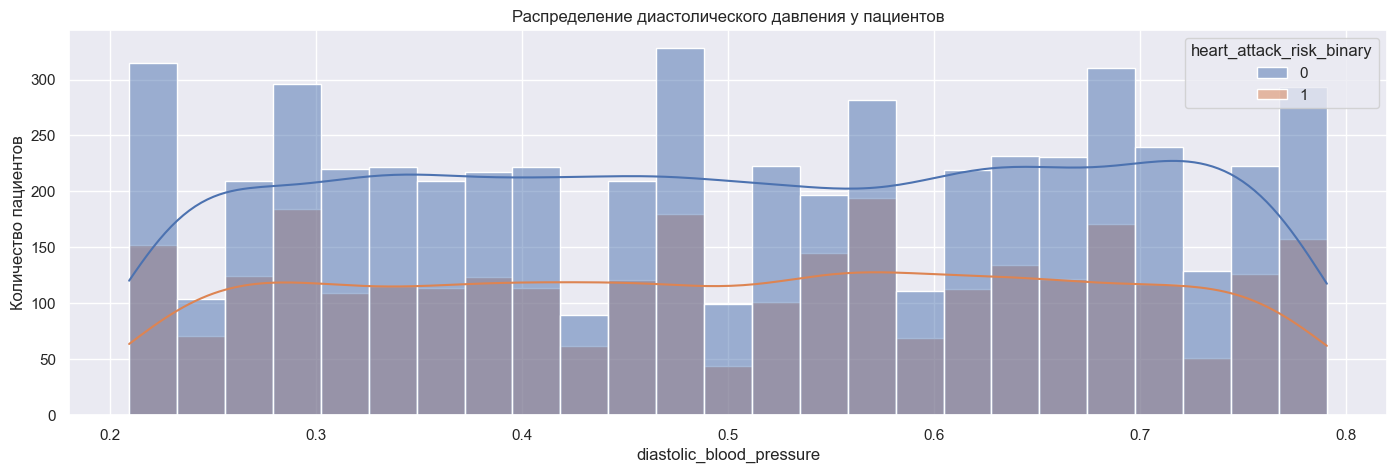

In [53]:
print_hist(df, 
           'diastolic_blood_pressure', 
           'heart_attack_risk_binary',
           'Распределение диастолического давления у пациентов'
          )

Данные находятся в диапазоне от 0 до 1. Значения диастолического давления больше значений из датафрейма. Скорее всего данные были заранее нормализованы, что бы не разглашать данные реальных пациентов

In [54]:
# Изучим столбец 'diabetes'
df['diabetes'].unique()

array([1, 0])

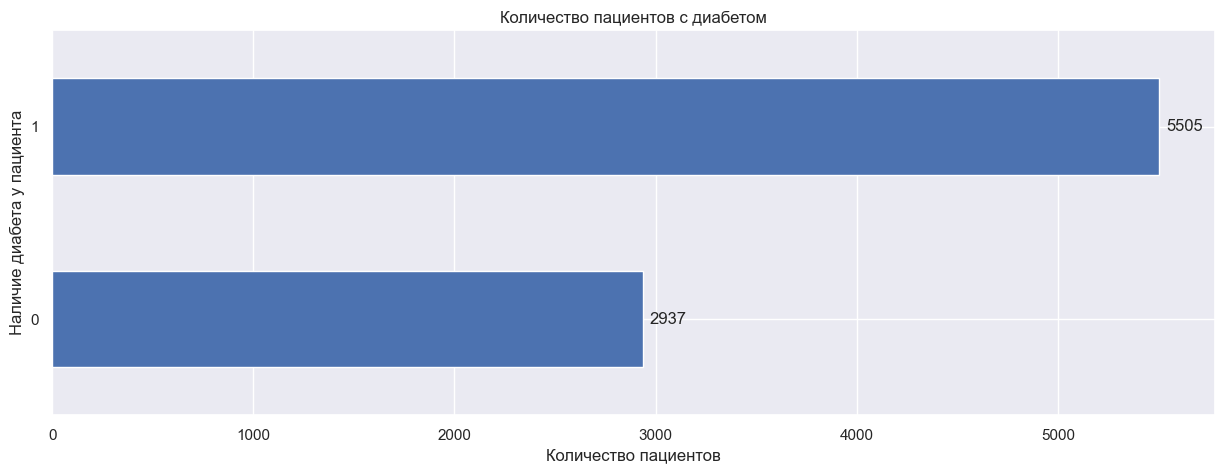

In [55]:
print_barh(df['diabetes'])
plt.title('Количество пациентов с диабетом')
plt.xlabel('Количество пациентов')
plt.ylabel('Наличие диабета у пациента')
plt.show()

In [56]:
# Изучим столбец 'family_history'
df['family_history'].unique()

array([1, 0])

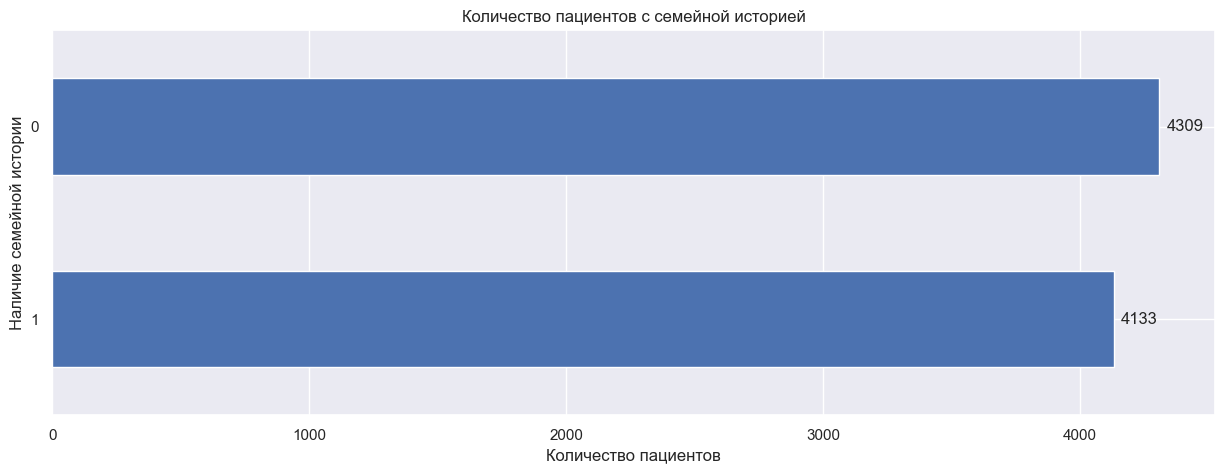

In [57]:
print_barh(df['family_history'])
plt.title('Количество пациентов с семейной историей')
plt.xlabel('Количество пациентов')
plt.ylabel('Наличие семейной истории')
plt.show()

In [58]:
# Изучим столбец 'smoking'
df['smoking'].unique()

array([1, 0])

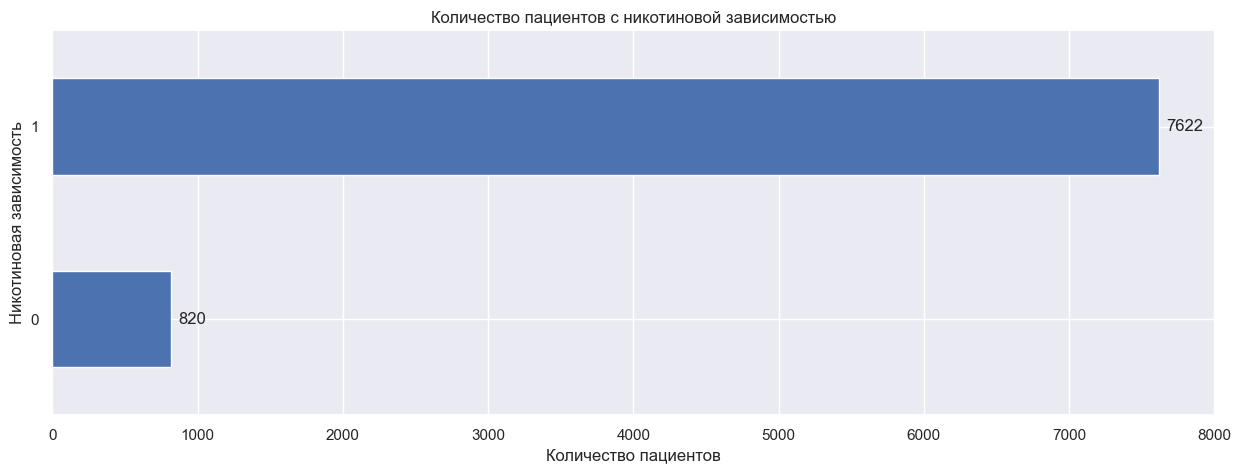

In [59]:
print_barh(df['smoking'])
plt.title('Количество пациентов с никотиновой зависимостью')
plt.xlabel('Количество пациентов')
plt.ylabel('Никотиновая зависимость')
plt.show()

In [60]:
# Изучим столбец 'obesity'
df['obesity'].unique()

array([1, 0])

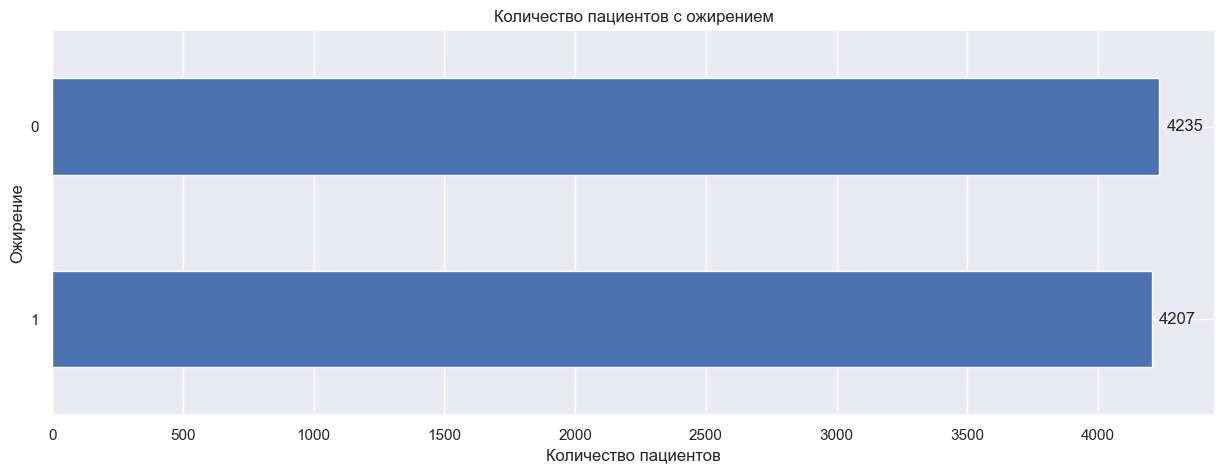

In [61]:
print_barh(df['obesity'])
plt.title('Количество пациентов с ожирением')
plt.xlabel('Количество пациентов')
plt.ylabel('Ожирение')
plt.show()

In [62]:
# Изучим столбец 'alcohol_consumption'
df['alcohol_consumption'].unique()

array([1, 0])

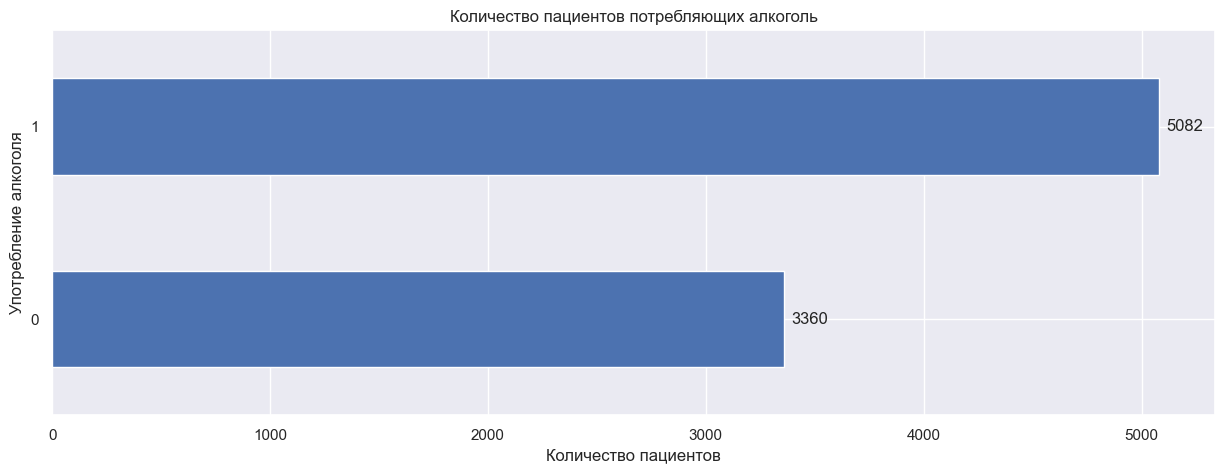

In [63]:
print_barh(df['alcohol_consumption'])
plt.title('Количество пациентов потребляющих алкоголь')
plt.xlabel('Количество пациентов')
plt.ylabel('Употребление алкоголя')
plt.show()

In [64]:
# Изучим столбец 'diet'
df['diet'].unique()

array([1, 2, 0], dtype=int64)

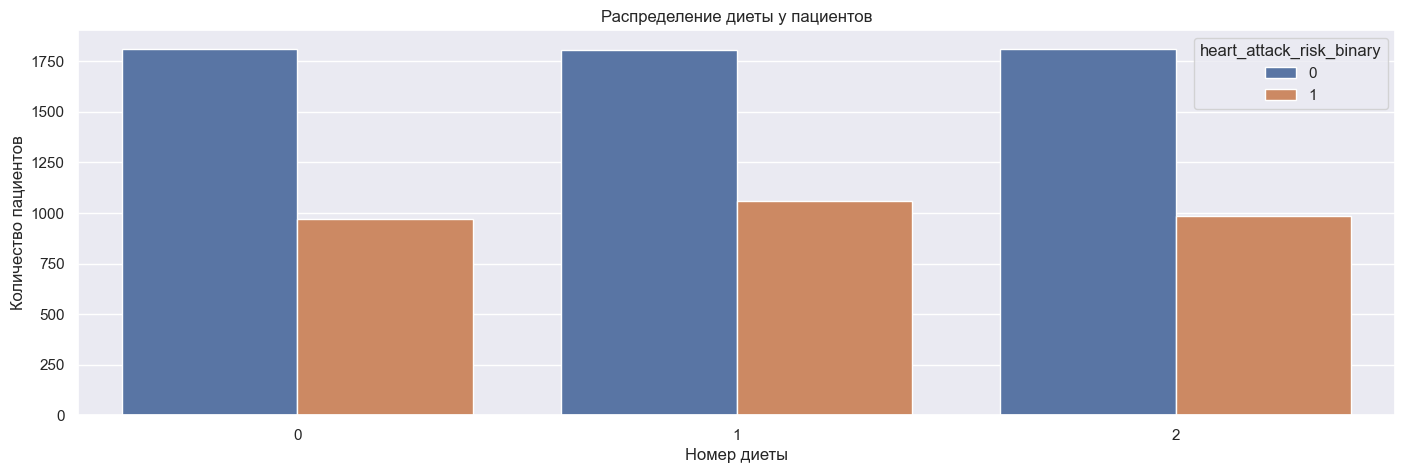

In [65]:
plt.figure(figsize=(17, 5))
sns.countplot(data = df,
              x = 'diet', 
              hue = 'heart_attack_risk_binary')
plt.title('Распределение диеты у пациентов')
plt.xlabel('Номер диеты')
plt.ylabel('Количество пациентов')
plt.show;

In [66]:
# Изучим столбец 'previous_heart_problems'
df['previous_heart_problems'].unique()

array([1, 0])

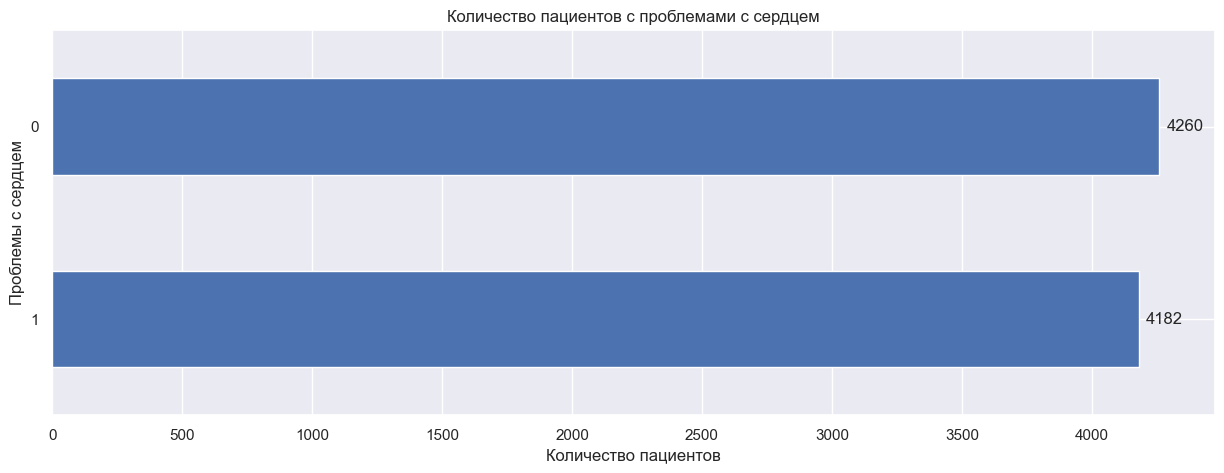

In [67]:
print_barh(df['previous_heart_problems'])
plt.title('Количество пациентов с проблемами с сердцем')
plt.xlabel('Количество пациентов')
plt.ylabel('Проблемы с сердцем')
plt.show()

In [68]:
# Изучим столбец 'medication_use'
df['medication_use'].unique()

array([0, 1])

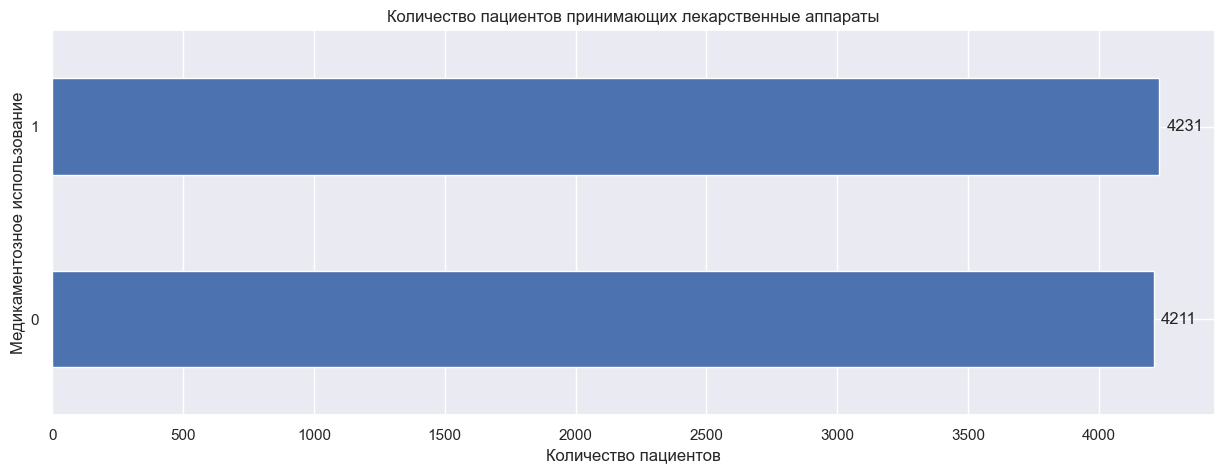

In [69]:
print_barh(df['medication_use'])
plt.title('Количество пациентов принимающих лекарственные аппараты')
plt.xlabel('Количество пациентов')
plt.ylabel('Медикаментозное использование')
plt.show()

In [70]:
# Изучим столбец 'stress_level'
df['stress_level'].unique()

array([ 8,  9,  6,  3,  7,  1, 10,  2,  5,  4])

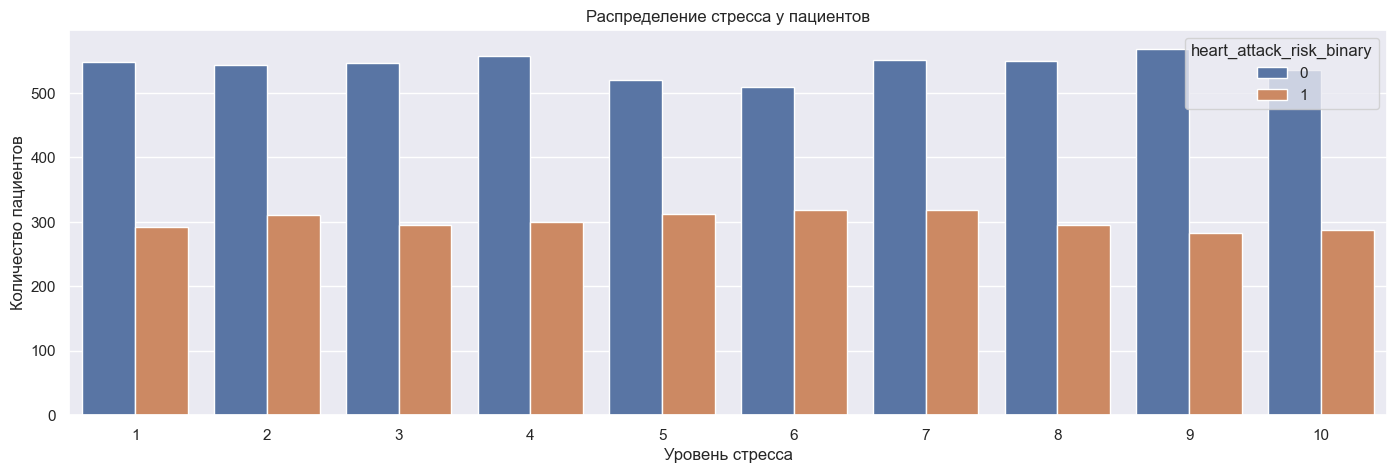

In [71]:
plt.figure(figsize=(17, 5))
sns.countplot(data = df,
              x = 'stress_level', 
              hue = 'heart_attack_risk_binary')
plt.title('Распределение стресса у пациентов')
plt.xlabel('Уровень стресса')
plt.ylabel('Количество пациентов')
plt.show;

In [72]:
# Изучим столбец 'physical_activity_days_per_week'
df['physical_activity_days_per_week'].unique()

array([3, 2, 0, 5, 6, 4, 7, 1])

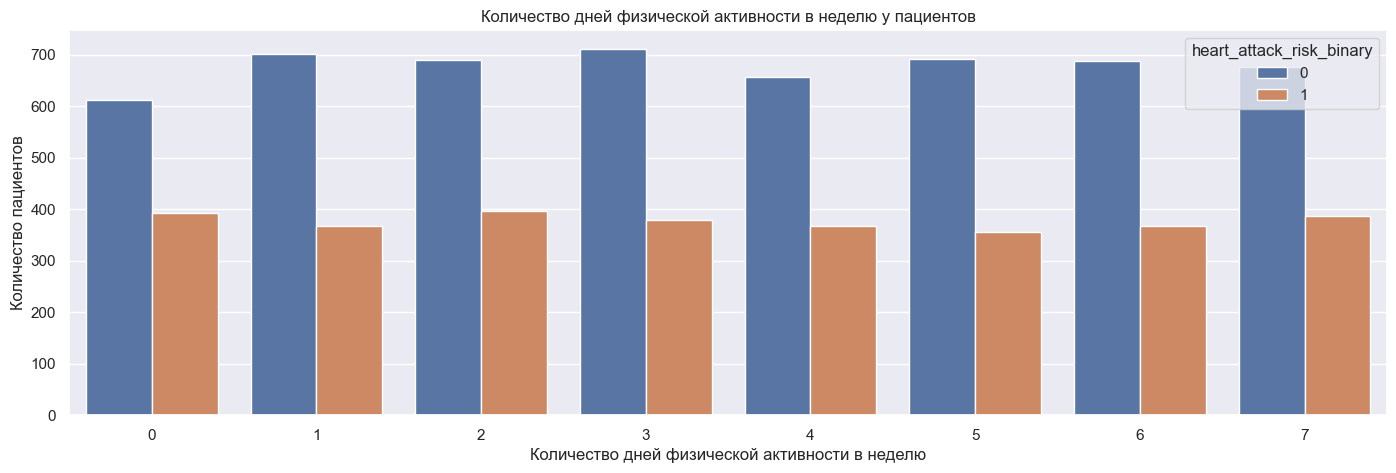

In [73]:
plt.figure(figsize=(17, 5))
sns.countplot(data = df,
              x = 'physical_activity_days_per_week', 
              hue = 'heart_attack_risk_binary')
plt.title('Количество дней физической активности в неделю у пациентов')
plt.xlabel('Количество дней физической активности в неделю')
plt.ylabel('Количество пациентов')
plt.show;

In [74]:
# Изучим столбец 'heart_attack_risk_binary'
df['heart_attack_risk_binary'].unique()

array([0, 1])

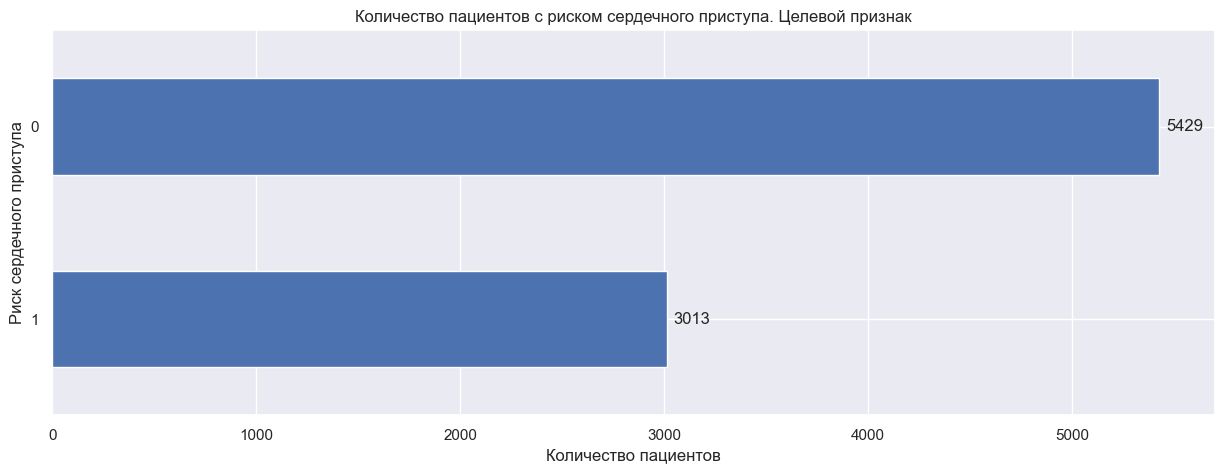

In [75]:
print_barh(df['heart_attack_risk_binary'])
plt.title('Количество пациентов с риском сердечного приступа. Целевой признак')
plt.xlabel('Количество пациентов')
plt.ylabel('Риск сердечного приступа')
plt.show()

In [76]:
# Изучим столбец 'gender'
df['gender'].unique()

array(['Male', 'Female'], dtype=object)

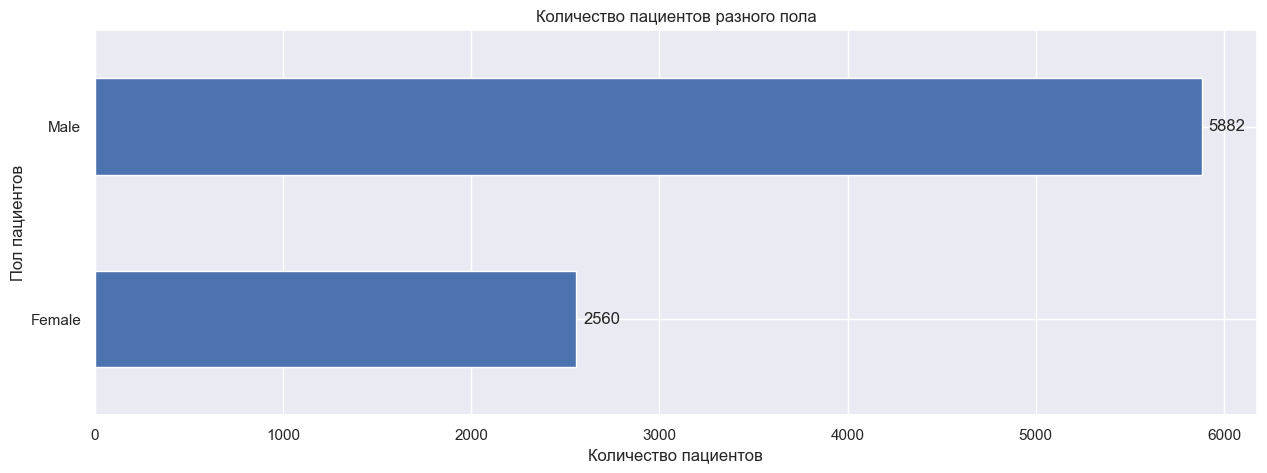

In [77]:
print_barh(df['gender'])
plt.title('Количество пациентов разного пола')
plt.xlabel('Количество пациентов')
plt.ylabel('Пол пациентов')
plt.show()

In [78]:
#Посчитаем сколько данных сохранилось после исследовательского анализа данных
new_df_shape = df.shape[0]
if (new_df_shape / old_df_shape) > 0.9:
    print('Количество отброшенных данных меньше допустимого. Можно работать дальше')
else:
    print('Количество отброшенных данных больше допустимого. Необходимо проверить анализ')
print('Количество сохраненных данных {:.2%}'.format(new_df_shape / old_df_shape))

Количество отброшенных данных меньше допустимого. Можно работать дальше
Количество сохраненных данных 97.20%


**Вывод**
Привели название столбцов к единому стилю.

У 31 пациента есть все пропущенные значения. Часть столбцов полностью идентичны. Удалили этих пациентов.

Количественные данные находятся в диапазоне от 0 до 1. Скорее всего данные были заранее нормализованы, что бы не разглашать данные реальных пациентов

## Корреляционный анализ

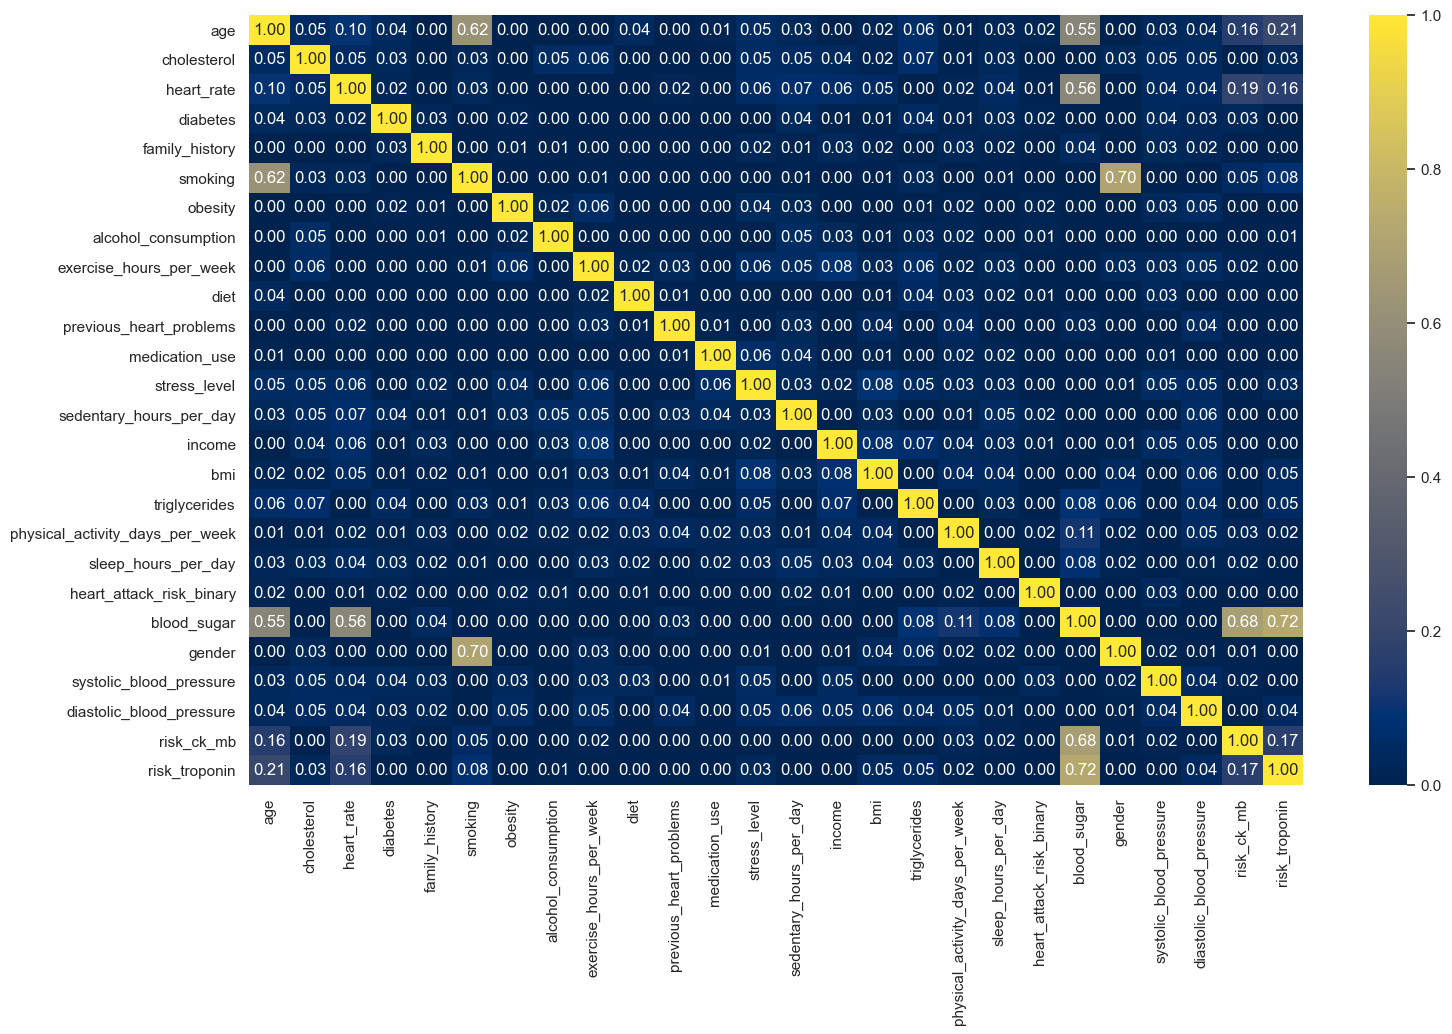

In [79]:
# Коэффициенты корреляции Фи
interval_cols = ['age', 
                 'cholesterol', 
                 'heart_rate', 
                 'exercise_hours_per_week', 
                 'sedentary_hours_per_day', 
                 'income',
                'bmi',
                'triglycerides',
                'systolic_blood_pressure',
                'diastolic_blood_pressure']
plt.figure(figsize=(17, 10))
sns.heatmap(
    df.phik_matrix(verbose=False, interval_cols=interval_cols),#, bins=100),
    annot=True,
    fmt='.2f',
    cmap='cividis'
);

## Пайплайн

В целевых данных наблюдается дисбаланс классов. Необходимо будет сделать стратификацию данных

In [80]:
# Задаем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [81]:
# Отделяем целевые и входные признаки
X = df.drop(columns='heart_attack_risk_binary')
y = df['heart_attack_risk_binary']
X.shape

(8442, 25)

In [82]:
# Тестовые данные оставляем на потом
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
) 

Количественный данные отмаcштабированны

In [83]:
# Выберем данные которые требуют кодирования
ohe_col_names = ['gender']

Отмасштабируем категорийные данные в столбцах 'diet', 'stress_level', 'physical_activity_days_per_week' для того что бы данные были одинаково нормализованны

In [84]:
# Выберем данные которые требуют масштабирования
num_col_names = ['diet', 'stress_level', 'physical_activity_days_per_week']

In [85]:
# Создадим пайплайн для кодирования
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

In [86]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col_names),
        ('num', MinMaxScaler(), num_col_names)
    ], 
    remainder='passthrough'
) 

In [87]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 

In [88]:
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors' : range(2, 4),
        'models__weights': ['uniform', 'distance'],
        'models__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },

    # словарь для модели XGB_model()
    {
        'models': [XGBClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5)
    },

    # словарь для модели DecisionTreeClassifier()
    {
       'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth' : range(2, 6),
        'models__max_features' : range(2, 6)
    }
]

In [89]:
# Сохраняем пропорции классов в каждом разбиении
cv = StratifiedKFold(n_splits=5)

In [90]:
# Поиск гиперпараметров
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='f1', 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=500,
    cv=cv
)
randomized_search.fit(X_train, y_train) 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['g...
                                                                  max_leaves=None,
                                                                  min_child_weight=None,
                                                                  missing=nan,
                                                                  monotone_constraints=None,
                                                                  multi_strategy=None,
                                                                  n_estimators=None,
                                                                  n_jobs=None,
                                                                  num_parallel_tree=None,
                                                                  random_state=42, ...)],
                                         'models__max_depth': range(2, 5)},
                                        {'models': [DecisionTreeClassifier(random_state=42)],
                                         'models__max_depth': range(2, 6),
                                         'models__max_features': range(2, 6)}],
                   random_state=42, scoring='f1')

In [91]:
print('Метрика F1 для лучшей модели:\n {:.2%}'.format(randomized_search.best_score_))
print('Параметры лучшей модели:\n', randomized_search.best_estimator_) 

Метрика F1 для лучшей модели:
 39.10%
Параметры лучшей модели:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender']),
                                                 ('num', MinMaxScaler(),
                                                  ['diet', 'stress_level

In [92]:
result = pd.DataFrame(randomized_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head()

,rank_test_score,param_models,mean_test_score,params
1,1,KNeighborsClassifier(),0.390992,"{'models__weights': 'distance', 'models__n_nei..."
5,1,KNeighborsClassifier(),0.390992,"{'models__weights': 'distance', 'models__n_nei..."
9,1,KNeighborsClassifier(),0.390992,"{'models__weights': 'distance', 'models__n_nei..."
13,1,KNeighborsClassifier(),0.390992,"{'models__weights': 'distance', 'models__n_nei..."
3,5,KNeighborsClassifier(),0.350511,"{'models__weights': 'distance', 'models__n_nei..."


In [93]:
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print('Метрика f1 на тестовой выборке: {:.2%}'.format(f1_score(y_test,y_test_pred)))
print('Метрика ROC-AUC на тестовой выборке: {:.2%}'.format(roc_auc_score(y_test, y_test_proba[:,1])))

Метрика f1 на тестовой выборке: 39.10%
Метрика ROC-AUC на тестовой выборке: 54.23%


In [94]:
best_model = randomized_search.best_estimator_.named_steps['models']
best_model

KNeighborsClassifier(n_neighbors=2, weights='distance')

In [95]:
# Сохраняем модель для приложения
pipe_app = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', best_model)
    ]
) 
pipe_app.fit(X_train, y_train)
with open('./model.pkl', 'wb') as model_pkl:
  pickle.dump(pipe_app, model_pkl)

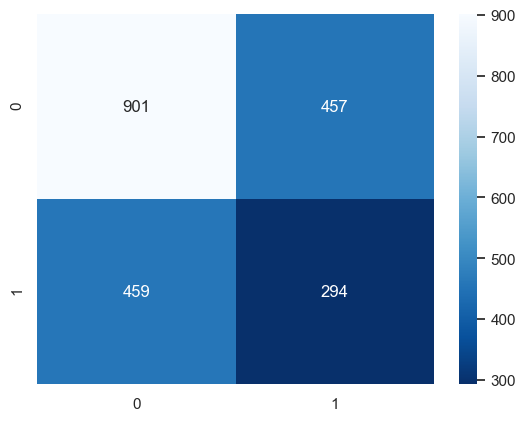

In [96]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');

In [97]:
preprocessor_best = randomized_search.best_estimator_.named_steps['preprocessor']

In [98]:
preprocessor_best.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['gender']),
                                ('num', MinMaxScaler(),
                                 ['diet', 'stress_level',
                                  'physical_activity_days_per_week'])])

In [99]:
feature_names = preprocessor_best.get_feature_names_out()

In [100]:
X_train_new = preprocessor_best.fit_transform(X_train)
X_test_new = preprocessor_best.transform(X_test)

In [101]:
explainer = shap.Explainer(best_model.predict_proba, X_train_new, feature_names=feature_names)
shap_values = explainer(X_test_new)

PermutationExplainer explainer: 2112it [40:42,  1.16s/it]                      


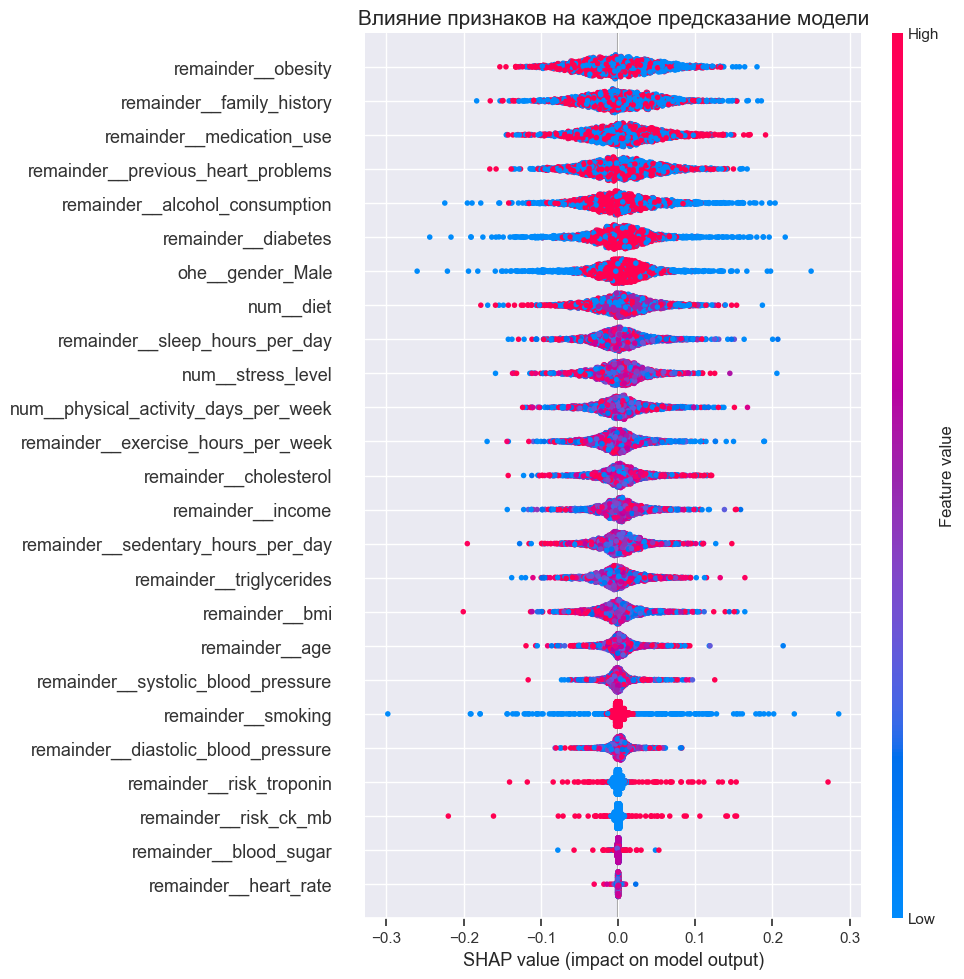

In [102]:
plt.title('Влияние признаков на каждое предсказание модели', size=15)
shap.plots.beeswarm(shap_values[:,:,1], max_display=40)

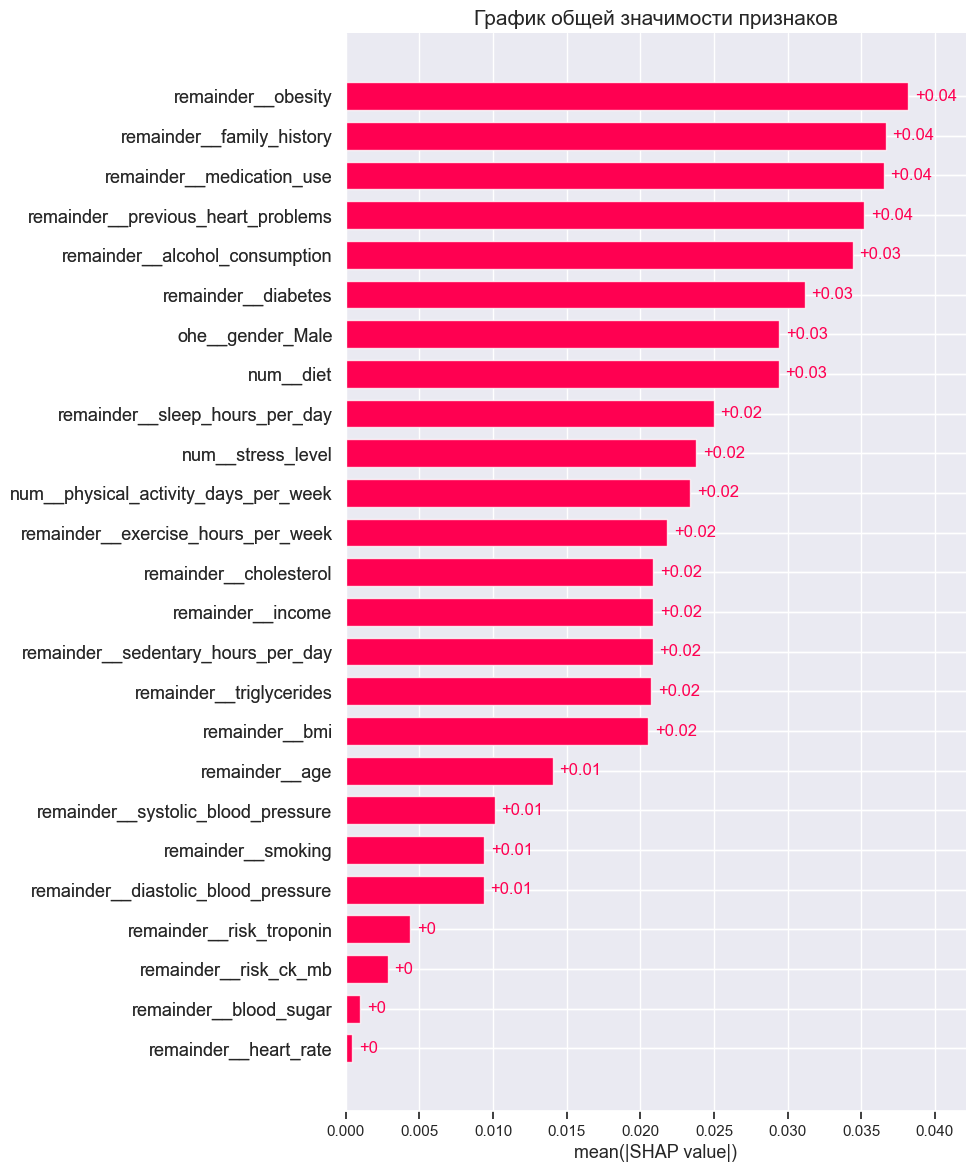

In [103]:
shap.plots.bar(shap_values[:,:,1], max_display=40, show=False)
plt.title('График общей значимости признаков', size=15)
plt.show()

Лучшей моделью стала KNeighborsClassifier()	с гиперпараметрами n_neighbors=2, weights='distance'

F1 на тренировочной выборке 39.87%

F1 на тестовой выборке 40.92%

По анализу признаков которые не влияют на модель можно отметить:

- heart_rate
- blood_sugar
- risk_ck_mb
- risk_troponin 

## Catboost

In [104]:
# Выберем категорийные данные которые требуют кодирования
cat_features = ['gender']

In [105]:
# Подбор гиперпараметров для CatBoost
# Определение сетки параметров
param_grid = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.1, 0.4, 0.9],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [3, 5]
}

# Создание модели
model = CatBoostClassifier(
    random_seed=RANDOM_STATE,
    verbose=0,
    cat_features=cat_features
)

# Поиск по сетке
randomizedSearch_cat = RandomizedSearchCV(
    model,
    param_grid, 
    cv=cv, 
    scoring='f1',
    n_jobs=-1, 
    verbose=1
)

randomizedSearch_cat.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000002A1D6DED520>,
                   n_jobs=-1,
                   param_distributions={'depth': [4, 6, 8],
                                        'iterations': [100, 500, 1000],
                                        'l2_leaf_reg': [3, 5],
                                        'learning_rate': [0.1, 0.4, 0.9]},
                   scoring='f1', verbose=1)

In [106]:
print(f"Лучшие параметры CatBoost: {randomizedSearch_cat.best_params_}")
print(f"Лучший результат f1 CatBoost: {randomizedSearch_cat.best_score_:.4f}")

Лучшие параметры CatBoost: {'learning_rate': 0.9, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 4}
Лучший результат f1 CatBoost: 0.3796


In [107]:
y_test_pred_cat = randomizedSearch_cat.predict(X_test)
y_test_proba_cat = randomizedSearch_cat.predict_proba(X_test)
print('Метрика f1 на тестовой выборке: {:.2%}'.format(f1_score(y_test,y_test_pred_cat)))
print('Метрика ROC-AUC на тестовой выборке: {:.2%}'.format(roc_auc_score(y_test, y_test_proba_cat[:,1])))

Метрика f1 на тестовой выборке: 37.80%
Метрика ROC-AUC на тестовой выборке: 55.87%


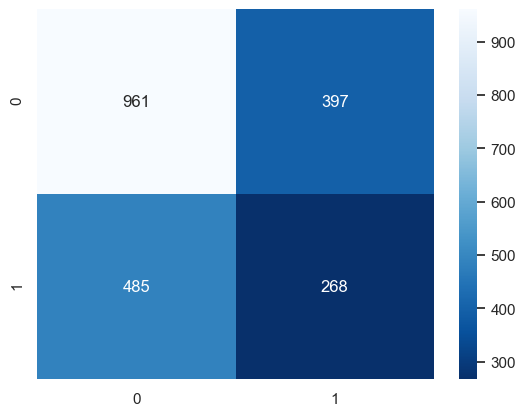

In [108]:
cm_cat = confusion_matrix(y_test, y_test_pred_cat)
sns.heatmap(cm_cat, annot=True, fmt='d', cmap='Blues_r');

## Работа с признаками

Создадим датафрейм без признаков которые не влияют на результат и посмотрим как изменятся метрики модели

In [109]:
# удалим столбец previous_heart_problems
drop = [
    'heart_rate',
    'risk_ck_mb',
    'risk_troponin',
    'blood_sugar',
]
df_drop = df.drop(drop, axis=1)

In [110]:
df_drop.head()

,age,cholesterol,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,
2664,0.359551,0.732143,1,1,1,1,1,0.535505,1,1,0,8,0.225704,0.105948,0.459176,0.979221,3,0.333333,0,Male,0.212903,0.709302
9287,0.202247,0.325000,1,1,0,0,1,0.068690,2,1,0,9,0.289923,0.164217,0.117053,0.515584,3,0.833333,0,Female,0.412903,0.569767
5379,0.606742,0.860714,1,0,1,1,1,0.944001,2,1,1,6,0.550133,0.598745,0.373574,0.012987,2,1.000000,0,Female,0.238710,0.220930
8222,0.730337,0.007143,0,0,1,0,1,0.697023,0,0,1,3,0.330962,0.077605,0.049735,0.131169,0,0.333333,1,Female,0.348387,0.267442
4047,0.775281,0.757143,0,0,1,0,1,0.412878,1,0,0,8,0.524600,0.341960,0.830405,0.070130,5,1.000000,1,Male,0.619355,0.441860


In [111]:
# Отделяем целевые и входные признаки
X = df_drop.drop(columns='heart_attack_risk_binary')
y = df_drop['heart_attack_risk_binary']
X.shape

(8442, 21)

In [112]:
# Тестовые данные оставляем на потом
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
) 

In [113]:
# Поиск гиперпараметров
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='f1', 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=500,
    cv=cv
)
randomized_search.fit(X_train, y_train) 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['g...
                                                                  max_leaves=None,
                                                                  min_child_weight=None,
                                                                  missing=nan,
                                                                  monotone_constraints=None,
                                                                  multi_strategy=None,
                                                                  n_estimators=None,
                                                                  n_jobs=None,
                                                                  num_parallel_tree=None,
                                                                  random_state=42, ...)],
                                         'models__max_depth': range(2, 5)},
                                        {'models': [DecisionTreeClassifier(random_state=42)],
                                         'models__max_depth': range(2, 6),
                                         'models__max_features': range(2, 6)}],
                   random_state=42, scoring='f1')

In [114]:
print('Метрика F1 для лучшей модели:\n {:.2%}'.format(randomized_search.best_score_))
print('Параметры лучшей модели:\n', randomized_search.best_estimator_) 

Метрика F1 для лучшей модели:
 39.59%
Параметры лучшей модели:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender']),
                                                 ('num', MinMaxScaler(),
                                                  ['diet', 'stress_level

In [115]:
result = pd.DataFrame(randomized_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head()

,rank_test_score,param_models,mean_test_score,params
1,1,KNeighborsClassifier(),0.395856,"{'models__weights': 'distance', 'models__n_nei..."
5,1,KNeighborsClassifier(),0.395856,"{'models__weights': 'distance', 'models__n_nei..."
9,1,KNeighborsClassifier(),0.395856,"{'models__weights': 'distance', 'models__n_nei..."
13,1,KNeighborsClassifier(),0.395856,"{'models__weights': 'distance', 'models__n_nei..."
3,5,KNeighborsClassifier(),0.364463,"{'models__weights': 'distance', 'models__n_nei..."


In [116]:
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print('Метрика f1 на тестовой выборке: {:.2%}'.format(f1_score(y_test,y_test_pred)))
print('Метрика ROC-AUC на тестовой выборке: {:.2%}'.format(roc_auc_score(y_test, y_test_proba[:,1])))

Метрика f1 на тестовой выборке: 38.96%
Метрика ROC-AUC на тестовой выборке: 54.82%


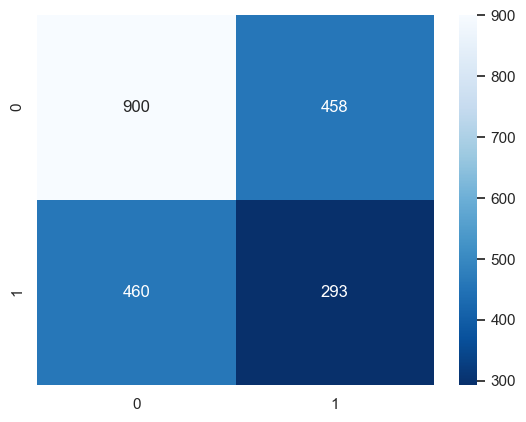

In [117]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');

**Вывод**

Модель Catboost показала похожие результаты метрик, но оставим модель KNeighborsClassifier(), так как у нее большее значение метрики F1

Удаление не используемых признаков модель не улучшили.

Используем модель KNeighborsClassifier() для предсказания результатов на втором датафрейме

## Классы для работы приложения

In [118]:
logger = logging.getLogger(__name__)

class Dataset:
    def __init__(self, data: pd.DataFrame):
        """Инициализация с преобразованием названий столбцов и валидацией"""
        self.required_features = [
            'age', 'gender', 'bmi',
            'cholesterol',
            'triglycerides', 'ck_mb', 'troponin',
            'diabetes', 'family_history', 'smoking', 'obesity',
            'alcohol_consumption', 'previous_heart_problems',
            'medication_use', 'diet', 'stress_level',
            'physical_activity_days_per_week'
        ]

        # Сначала преобразуем названия столбцов
        self.data = self._clean_column_names(data.copy())

        # Затем выполняем валидацию
        self._validate_input(self.data)

    def _clean_column_names(self, df: pd.DataFrame) -> pd.DataFrame:
        """Приведение названий столбцов к единому стилю"""
        df.columns = (
            df.columns
            .str.lower()  # в нижний регистр
            .str.strip()  # убираем пробелы по краям
            .str.replace(r'[:()\s\-/]', '_', regex=True)  # заменяем спецсимволы на подчеркивание
            .str.replace(r'_+', '_', regex=True)  # заменяем множественные подчеркивания на одно
            .str.rstrip('_')  # убираем подчеркивание в конце
        )
        return df

    def _validate_input(self, df: pd.DataFrame):
        """Валидация входных данных после преобразования названий столбцов"""
        missing = [req_col for req_col in self.required_features
                  if req_col not in df.columns]

        if missing:
            raise ValueError(
                f"Отсутствуют обязательные признаки: {', '.join(missing)}\n"
                f"Имеющиеся столбцы: {', '.join(df.columns)}"
            )

    def _convert_to_int(self, df: pd.DataFrame) -> pd.DataFrame:
        """Преобразование указанных столбцов в целые числа"""
        int_columns = [
            'diabetes', 'family_history', 'smoking', 'obesity',
            'alcohol_consumption', 'previous_heart_problems',
            'medication_use', 'stress_level',
            'physical_activity_days_per_week'
        ]

        for col in int_columns:
            if col in df.columns:
                # Безопасное преобразование
                df[col] = pd.to_numeric(df[col], errors='coerce').astype(int)
        return df

    def _process_biomarkers(self, df: pd.DataFrame) -> pd.DataFrame:
        """Обработка биомаркеров и создание бинарных признаков"""
        # Обработка CK-MB
        if 'ck_mb' in df.columns:
            df['ck_mb'] = pd.to_numeric(df['ck_mb'], errors='coerce')
            df['risk_ck_mb'] = (df['ck_mb'] >= 0.05).astype(int)
            df = df.drop('ck_mb', axis=1, errors='ignore')

        # Обработка тропонина
        if 'troponin' in df.columns:
            df['troponin'] = pd.to_numeric(df['troponin'], errors='coerce')
            df['risk_troponin'] = (df['troponin'] >= 0.04).astype(int)
            df = df.drop('troponin', axis=1, errors='ignore')

        return df

    def preprocess(self) -> pd.DataFrame:
        """Основной метод предобработки данных"""
        try:
            df = self.data.copy()

            # Удаление ненужных столбцов
            df = df.drop(columns=['unnamed'], errors='ignore')

            # Заменим индексы на id пациентов
            df = df.set_index('id')

            # Удаление строк с пропущенными значениями
            df = df.dropna()

            # Преобразование типов
            df = self._convert_to_int(df)

            # Обработка биомаркеров
            df = self._process_biomarkers(df)

            # Проверка, что остались данные после предобработки
            if df.empty:
                raise ValueError("После предобработки данных не осталось - проверьте входные данные")

            return df

        except Exception as e:
            logger.error(f"Ошибка предобработки данных: {str(e)}")
            raise ValueError(f"Ошибка предобработки данных: {str(e)}")

In [119]:
class Models:
    def __init__(self, model_path: str = "model.pkl"):
        """Инициализация с загрузкой предварительно обученной модели"""
        self.model_path = Path(model_path)
        if not self.model_path.exists():
            raise FileNotFoundError(f"Model file not found at {model_path}")

        # Загружаем модель
        with open(self.model_path, 'rb') as f:
            self.pipe_final = pickle.load(f)

    def model(self, df: pd.DataFrame) -> pd.DataFrame:
        """Получение предсказаний от загруженной модели"""
        # Проверка необходимых колонок
        required_cols = ['gender', 'diet', 'stress_level', 'physical_activity_days_per_week']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Отсутствуют обязательные признаки: {', '.join(missing_cols)}")

        try:
            # Получаем предсказания
            proba = pd.DataFrame(
                self.pipe_final.predict_proba(df)[:, 1],
                columns=['proba'],
                index=df.index
            ).reset_index()
            predict = pd.DataFrame(
                self.pipe_final.predict(df),
                columns=['predict'],
                index=df.index
            ).reset_index()
            return proba, predict
        except Exception as e:
            raise RuntimeError(f"Ошибка при получении предсказаний: {str(e)}")

## Обработка датафрейма test

In [120]:
#Загрузим необходимый датафрейм
data = pd.read_csv('heart_test.csv')

In [121]:
# Сделаем предобработку
data = Dataset(data).preprocess()

In [122]:
data.head()

,unnamed_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,gender,systolic_blood_pressure,diastolic_blood_pressure,risk_ck_mb,risk_troponin
id,,,,,,,,,,,,,,,,,,,,,,,,,,
7746,0,0.494382,0.264286,0.062328,0,1,1,1,1,0.361618,2,0,0,8,0.194370,0.587759,0.283490,0.306494,1,0.333333,0.227018,Male,0.283871,0.372093,0,0
4202,1,0.224719,0.953571,0.082493,1,0,0,1,0,0.996483,2,1,1,5,0.329888,0.602883,0.467036,0.087013,0,0.166667,0.227018,Female,0.703226,0.441860,0,0
6632,2,0.629213,0.092857,0.064161,0,1,1,1,0,0.995561,0,0,0,10,0.780075,0.370436,0.409366,0.205195,7,1.000000,0.102767,Male,0.458065,0.779070,0,1
4639,3,0.460674,0.567857,0.055912,1,1,1,1,1,0.437277,0,0,0,10,0.785071,0.368242,0.910261,0.163636,0,0.666667,0.203557,Female,0.741935,0.255814,1,1
4825,4,0.719101,0.485714,0.022915,1,0,1,0,1,0.514920,0,0,0,7,0.070919,0.729578,0.758924,0.580519,5,0.000000,0.227018,Male,0.412903,0.395349,0,0


In [123]:
# Получим предсказания выбранной модели
proba, predict = Models().model(data)

In [124]:
predict.to_csv('result_test.csv', index=False)

**Вывод**

В рамках работы по построению модели предсказания риска сердечного приступа выполнено:

1. Проведена загрузка и первичная оценка соответствия данных. Обнаружены незначительные пропуски в данных

2. Проведена предобработка данных:
   - Наименования колонок приведены к snake_case
   - Проверено наличия явных дубликатов. Явные дубликаты не обнаружены

3. Проведен анализ пропусков:
   - все пропуски находятся в одних и тех же строках
   - в этих строках находятся данные не схожими с другими строками

Принято решение исключить эти данные из датасетов

4. Проведён исследовательский анализ данных:
   - Распределение бинарных признаков, в основном, равномерное. Исключения - некурящие пациенты (менее 10% данных), женщины (около 30%) и диабетики (65%).
   - Категориальные признаки распределены равномерно, перекосов нет
   - Непрерывные признаки распределены, в основном, нормально. Признаки отнормированы
   - Явных зависимостей целевого признака от конкретного признака не установлено, что подтверждается матрицей корреляции
   - Заменены два количественных признака `ck_mb` и `troponin` на категорийные `risk_ck_mb` и `risk_troponin`

5. Проведено обучение и оценка нескольких моделей:
   - С помощью RandomizedSearchCV осуществлен подпор модели и её гиперпараметров
   - Лучшее значение метрики F1 стала KNeighborsClassifier() с гиперпараметрами n_neighbors=2, weights='distance'

F1 на тренировочной выборке 39.87%

F1 на тестовой выборке 40

6.  Обучена модель CatBoostClassifer с перебором гиперпараметров.

Модель Catboost показала похожие результаты метрик, но оставим модель KNeighborsClassifier(), так как у нее большее значение метрики F1

7. Выведены влияния признаков на модель. Удалены не используемые моделью признаки. 
Удаление не используемых признаков модель не улучшил

Используем модель KNeighborsClassifier() для предсказания результатов на втором датафрейме

8. Созданы классы для дальнейшего использования в приложении

10. Получено предсказание для тестовых данных и результаты сохранены в файл формата `csv`
 
sv`.92%
